In [1]:
# Fix randomness and hide warnings
seed = 42
%load_ext autoreload
%autoreload 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import matplotlib.pyplot as plt
plt.rc('font', size=16)

from C2.notebooks.Utils import split_dataset, build_sequences_optimized
from C2.notebooks.data_augmentation import augment_data

2.15.0


In [2]:
input_folder = '../data/training_dataset/'
training_data = np.load(input_folder + 'training_data.npy')
valid_periods = np.load(input_folder + 'valid_periods.npy')
categories = np.load(input_folder + 'categories.npy')

In [3]:
# categories to one hot
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(categories.reshape(-1, 1))
categories = enc.transform(categories.reshape(-1, 1)).toarray()

dataset, labels = build_sequences_optimized(training_data, valid_periods)
# train_validation_data, train_validation_labels, test_data, test_labels, train_validation_categories, test_categorie = split_dataset(dataset, labels, categories)
# 
# train_data, train_labels, validation_data, validation_labels, train_categories, validation_categories = split_dataset(train_validation_data, train_validation_labels, train_validation_categories, augment_train_data=False, num_augmentations=3)
# 
# train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
# train_labels = train_labels.reshape((train_labels.shape[0], train_labels.shape[1], 1))
# # validation_data = validation_data.reshape((validation_data.shape[0], validation_data.shape[1], 1))
# # validation_labels = validation_labels.reshape((validation_labels.shape[0], validation_labels.shape[1], 1))
# # test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
# # test_labels = test_labels.reshape((test_labels.shape[0], test_labels.shape[1], 1))
# train_data.shape

Dataset shape:  (48000, 200)


In [4]:
models = [file_name for file_name in os.listdir('../ensemble_models/models')]
models

['0052_ENC_DEC_FF_model.h5',
 '0059LSTM_ENC_DEC_model_attention_localMAE112_MSE0254__6epochs.h5',
 '0055_CNN_LSTM_CATEGORIES__OVERFIT_085_0164',
 '0065_resnet_5blocks_20epochs.h5',
 'lstm_model_step9.h5',
 '0073_resnet_3blocks.h5',
 '0055_CNN_LSTM_109_0253',
 'LSTM_best_18.h5',
 '0060mix_conv_lstm_conv_11_0255']

In [5]:
import sklearn
import pandas as pd
dataframe = pd.DataFrame()

predictions_all = np.zeros((labels.shape[0], labels.shape[1], len(models)*4))

for i, model_name in enumerate(models):
    print(model_name)
    model = tfk.models.load_model('../ensemble_models/models/' + model_name)
    if "cat" in model_name.lower():
        preds = model.predict([dataset, categories], batch_size=512*2)
        predictions_all[:, :, i] = preds
    elif "step9" in model_name.lower():
        preds1 = model.predict(dataset, batch_size=512*2)
        expanded_dataset = np.concatenate((dataset, preds1), axis=1)
        expanded_dataset = expanded_dataset[:, -200:]
        preds2 = model.predict(expanded_dataset, batch_size=512*2)
        preds = np.concatenate((preds1, preds2), axis=1)

        predictions_all[:, :, i] = preds
    else:
        preds = model.predict(dataset, batch_size=512*2)
        predictions_all[:, :, i] = preds

    predictions_all[:, :, i] = preds
    panads_entry = {}
    panads_entry['model_name'] = model_name
    panads_entry['mae'] = sklearn.metrics.mean_absolute_error(labels, preds)
    panads_entry['mse'] = sklearn.metrics.mean_squared_error(labels, preds)
    dataframe = dataframe.append(panads_entry, ignore_index=True)

# autoregressive
window = 3
prediction_len = 18
assert prediction_len % window == 0

for i, model_name in enumerate(models):
    j = len(models) + i
    print(model_name)
    model = tfk.models.load_model('../ensemble_models/models/' + model_name)
    expanded_dataset = dataset
    if "cat" in model_name.lower():
        for _ in range(prediction_len // window):
            pre = model.predict([expanded_dataset, categories], batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-prediction_len+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds
    elif "step9" in model_name.lower():
        for _ in range(prediction_len // window):
            pre = model.predict(expanded_dataset, batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-9+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds
    else:
        for _ in range(prediction_len // window):
            pre = model.predict(expanded_dataset, batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-prediction_len+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds

    panads_entry = {}
    panads_entry['model_name'] = model_name + "_autoregressive" + str(window)
    panads_entry['mae'] = sklearn.metrics.mean_absolute_error(labels, preds)
    panads_entry['mse'] = sklearn.metrics.mean_squared_error(labels, preds)
    dataframe = dataframe.append(panads_entry, ignore_index=True)


window = 6

for i, model_name in enumerate(models):
    j = len(models)*2 + i
    print(model_name)
    model = tfk.models.load_model('../ensemble_models/models/' + model_name)
    expanded_dataset = dataset
    if "cat" in model_name.lower():
        for _ in range(prediction_len // window):
            pre = model.predict([expanded_dataset, categories], batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-prediction_len+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds
    elif "step9" in model_name.lower():
        for _ in range(prediction_len // window):
            pre = model.predict(expanded_dataset, batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-9+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds
    else:
        for _ in range(prediction_len // window):
            pre = model.predict(expanded_dataset, batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-prediction_len+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds

    panads_entry = {}
    panads_entry['model_name'] = model_name + "_autoregressive" + str(window)
    panads_entry['mae'] = sklearn.metrics.mean_absolute_error(labels, preds)
    panads_entry['mse'] = sklearn.metrics.mean_squared_error(labels, preds)
    dataframe = dataframe.append(panads_entry, ignore_index=True)

window = 9
for i, model_name in enumerate(models):
    j = len(models)*3 + i
    print(model_name)
    model = tfk.models.load_model('../ensemble_models/models/' + model_name)
    expanded_dataset = dataset
    if "cat" in model_name.lower():
        for _ in range(prediction_len // window):
            pre = model.predict([expanded_dataset, categories], batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-prediction_len+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds
    elif "step9" in model_name.lower():
        for _ in range(prediction_len // window):
            pre = model.predict(expanded_dataset, batch_size=512*2)
            print(expanded_dataset.shape)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            print(expanded_dataset.shape)
            expanded_dataset = expanded_dataset[:, -200:]
            print(expanded_dataset.shape)
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds
    else:
        for _ in range(prediction_len // window):
            pre = model.predict(expanded_dataset, batch_size=512*2)
            expanded_dataset = np.concatenate((expanded_dataset, pre), axis=1)
            expanded_dataset = expanded_dataset[:, :-prediction_len+window]
            expanded_dataset = expanded_dataset[:, -200:]
        preds = expanded_dataset[:, -prediction_len:]
        predictions_all[:, :, j] = preds
        
    panads_entry = {}
    panads_entry['model_name'] = model_name + "_autoregressive" + str(window)
    panads_entry['mae'] = sklearn.metrics.mean_absolute_error(labels, preds)
    panads_entry['mse'] = sklearn.metrics.mean_squared_error(labels, preds)
    dataframe = dataframe.append(panads_entry, ignore_index=True)
    

0052_ENC_DEC_FF_model.h5
47/47 [==============================] - 3s 32ms/step
0059LSTM_ENC_DEC_model_attention_localMAE112_MSE0254__6epochs.h5
 1/47 [..............................] - ETA: 28s

W0000 00:00:1703173132.967409   11816 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1060" frequency: 1733 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5768871936 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


47/47 [==============================] - 3s 43ms/step
0055_CNN_LSTM_CATEGORIES__OVERFIT_085_0164
47/47 [==============================] - 2s 22ms/step
0065_resnet_5blocks_20epochs.h5
47/47 [==============================] - 5s 95ms/step
lstm_model_step9.h5
47/47 [==============================] - 1s 12ms/step
0073_resnet_3blocks.h5
47/47 [==============================] - 6s 122ms/step
0055_CNN_LSTM_109_0253
47/47 [==============================] - 2s 27ms/step
LSTM_best_18.h5
47/47 [==============================] - 1s 12ms/step
0060mix_conv_lstm_conv_11_0255
47/47 [==============================] - 3s 33ms/step
0052_ENC_DEC_FF_model.h5
47/47 [==============================] - 1s 32ms/step
0059LSTM_ENC_DEC_model_attention_localMAE112_MSE0254__6epochs.h5
 1/47 [..............................] - ETA: 35s

W0000 00:00:1703173189.458981   11816 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1060" frequency: 1733 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5768871936 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


47/47 [==============================] - 2s 45ms/step
0055_CNN_LSTM_CATEGORIES__OVERFIT_085_0164
47/47 [==============================] - 1s 20ms/step
0065_resnet_5blocks_20epochs.h5
47/47 [==============================] - 4s 85ms/step
lstm_model_step9.h5
47/47 [==============================] - 1s 12ms/step
0073_resnet_3blocks.h5
47/47 [==============================] - 6s 124ms/step
0055_CNN_LSTM_109_0253
47/47 [==============================] - 1s 27ms/step
LSTM_best_18.h5
47/47 [==============================] - 1s 12ms/step
0060mix_conv_lstm_conv_11_0255
47/47 [==============================] - 1s 29ms/step
0052_ENC_DEC_FF_model.h5
47/47 [==============================] - 2s 32ms/step
0059LSTM_ENC_DEC_model_attention_localMAE112_MSE0254__6epochs.h5
 3/47 [>.............................] - ETA: 1s 

W0000 00:00:1703173326.803226   11816 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1060" frequency: 1733 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5768871936 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


47/47 [==============================] - 2s 46ms/step
0055_CNN_LSTM_CATEGORIES__OVERFIT_085_0164
47/47 [==============================] - 1s 20ms/step
0065_resnet_5blocks_20epochs.h5
47/47 [==============================] - 4s 85ms/step
lstm_model_step9.h5
47/47 [==============================] - 1s 12ms/step
0073_resnet_3blocks.h5
47/47 [==============================] - 6s 124ms/step
0055_CNN_LSTM_109_0253
47/47 [==============================] - 1s 27ms/step
LSTM_best_18.h5
47/47 [==============================] - 1s 12ms/step
0060mix_conv_lstm_conv_11_0255
47/47 [==============================] - 1s 30ms/step
0052_ENC_DEC_FF_model.h5
47/47 [==============================] - 2s 32ms/step
0059LSTM_ENC_DEC_model_attention_localMAE112_MSE0254__6epochs.h5
 3/47 [>.............................] - ETA: 1s 

W0000 00:00:1703173406.502153   11816 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1060" frequency: 1733 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5768871936 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


47/47 [==============================] - 2s 45ms/step
0055_CNN_LSTM_CATEGORIES__OVERFIT_085_0164
47/47 [==============================] - 1s 20ms/step
0065_resnet_5blocks_20epochs.h5
47/47 [==============================] - 4s 85ms/step
lstm_model_step9.h5
47/47 [==============================] - 1s 12ms/step
(48000, 200)
(48000, 209)
(48000, 200)
47/47 [==============================] - 1s 12ms/step
(48000, 200)
(48000, 209)
(48000, 200)
0073_resnet_3blocks.h5
47/47 [==============================] - 6s 124ms/step
0055_CNN_LSTM_109_0253
47/47 [==============================] - 1s 26ms/step
LSTM_best_18.h5
47/47 [==============================] - 1s 12ms/step
0060mix_conv_lstm_conv_11_0255
47/47 [==============================] - 1s 30ms/step


In [6]:
sklearn.metrics.mean_absolute_error(labels, predictions_all.mean(axis=2))

0.08221581437824343

In [7]:
# dataframe2.to_csv('../ensemble_models/ensemble_models.csv')
# remove entries with model_name that ends with _autoregressive
models

['0052_ENC_DEC_FF_model.h5',
 '0059LSTM_ENC_DEC_model_attention_localMAE112_MSE0254__6epochs.h5',
 '0055_CNN_LSTM_CATEGORIES__OVERFIT_085_0164',
 '0065_resnet_5blocks_20epochs.h5',
 'lstm_model_step9.h5',
 '0073_resnet_3blocks.h5',
 '0055_CNN_LSTM_109_0253',
 'LSTM_best_18.h5',
 '0060mix_conv_lstm_conv_11_0255']

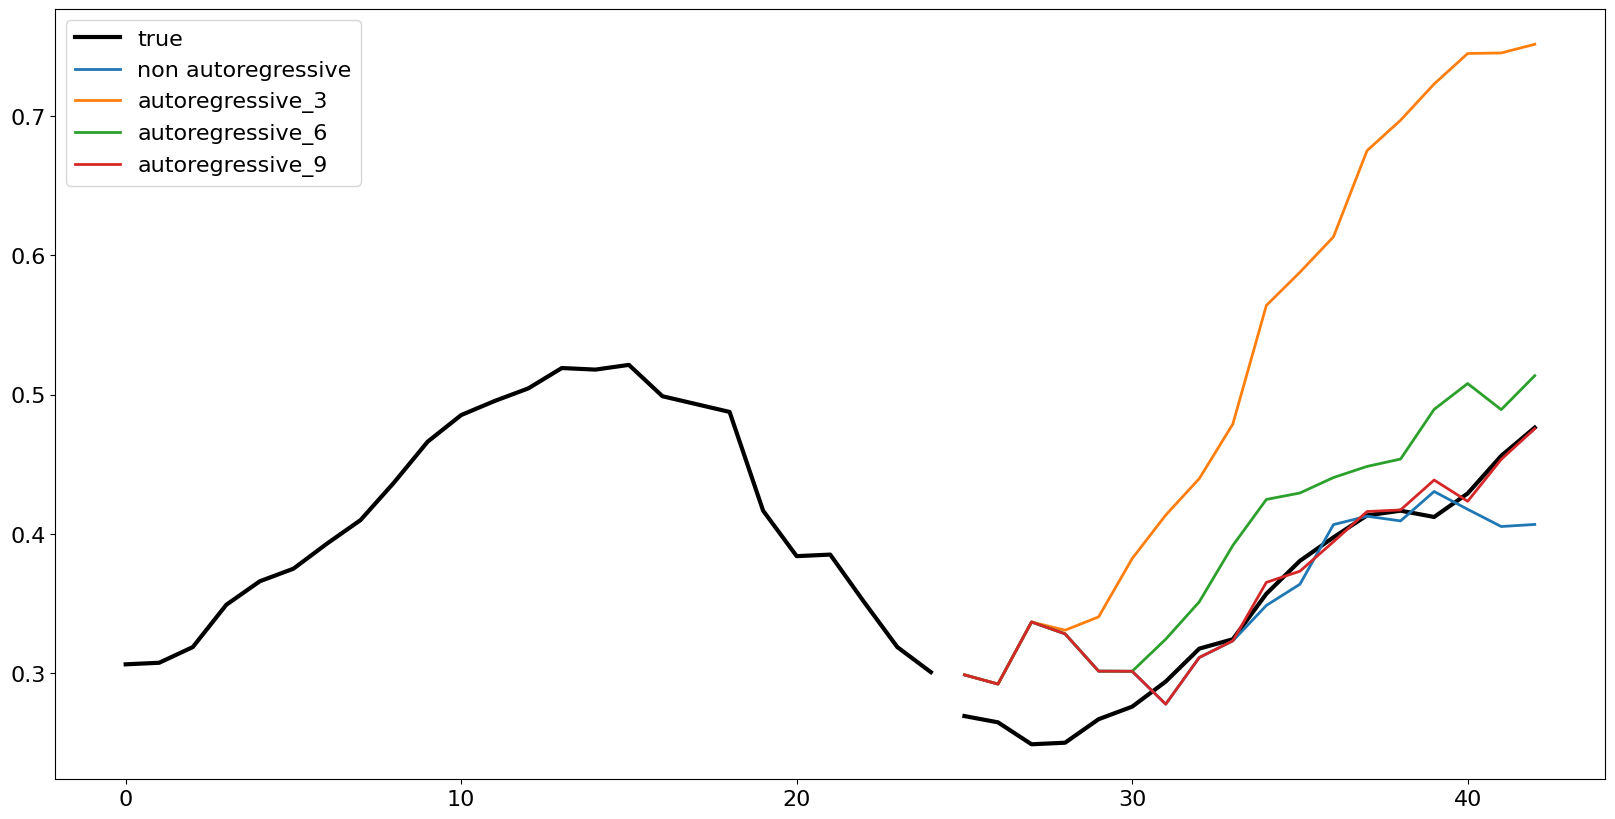

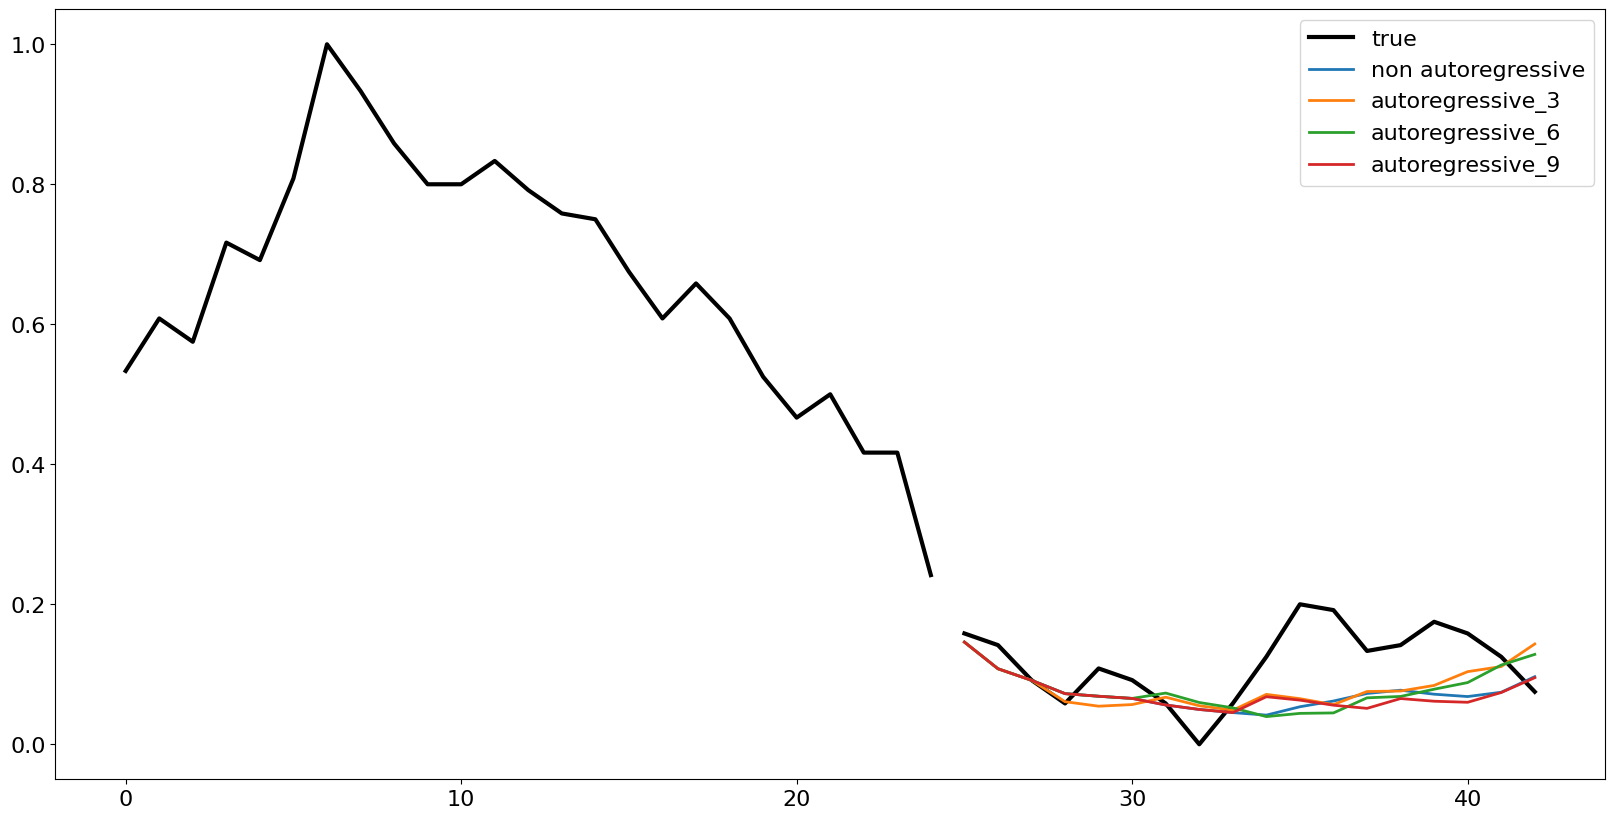

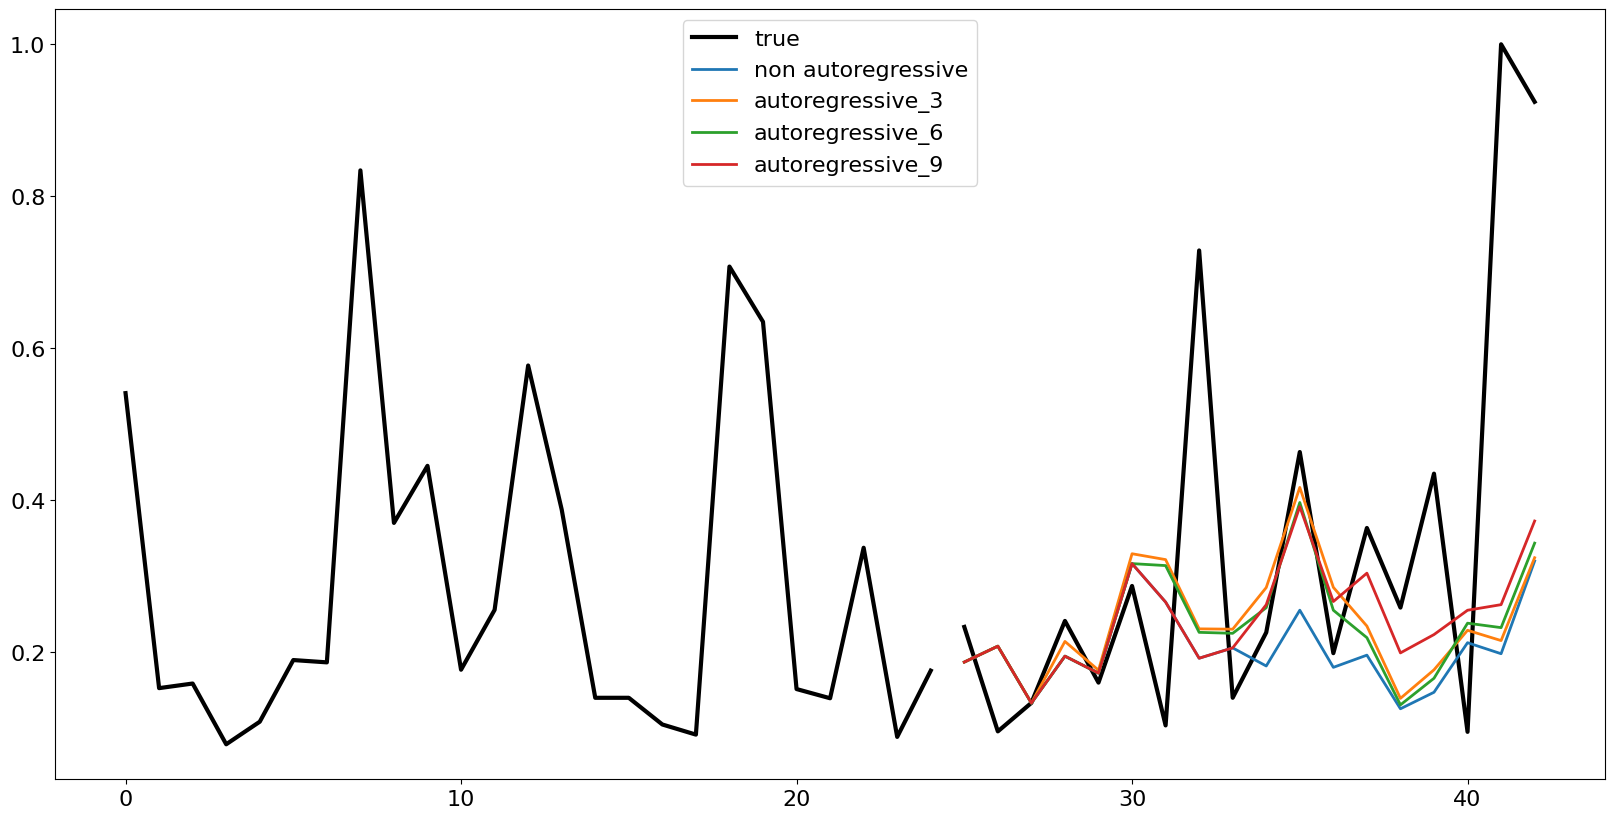

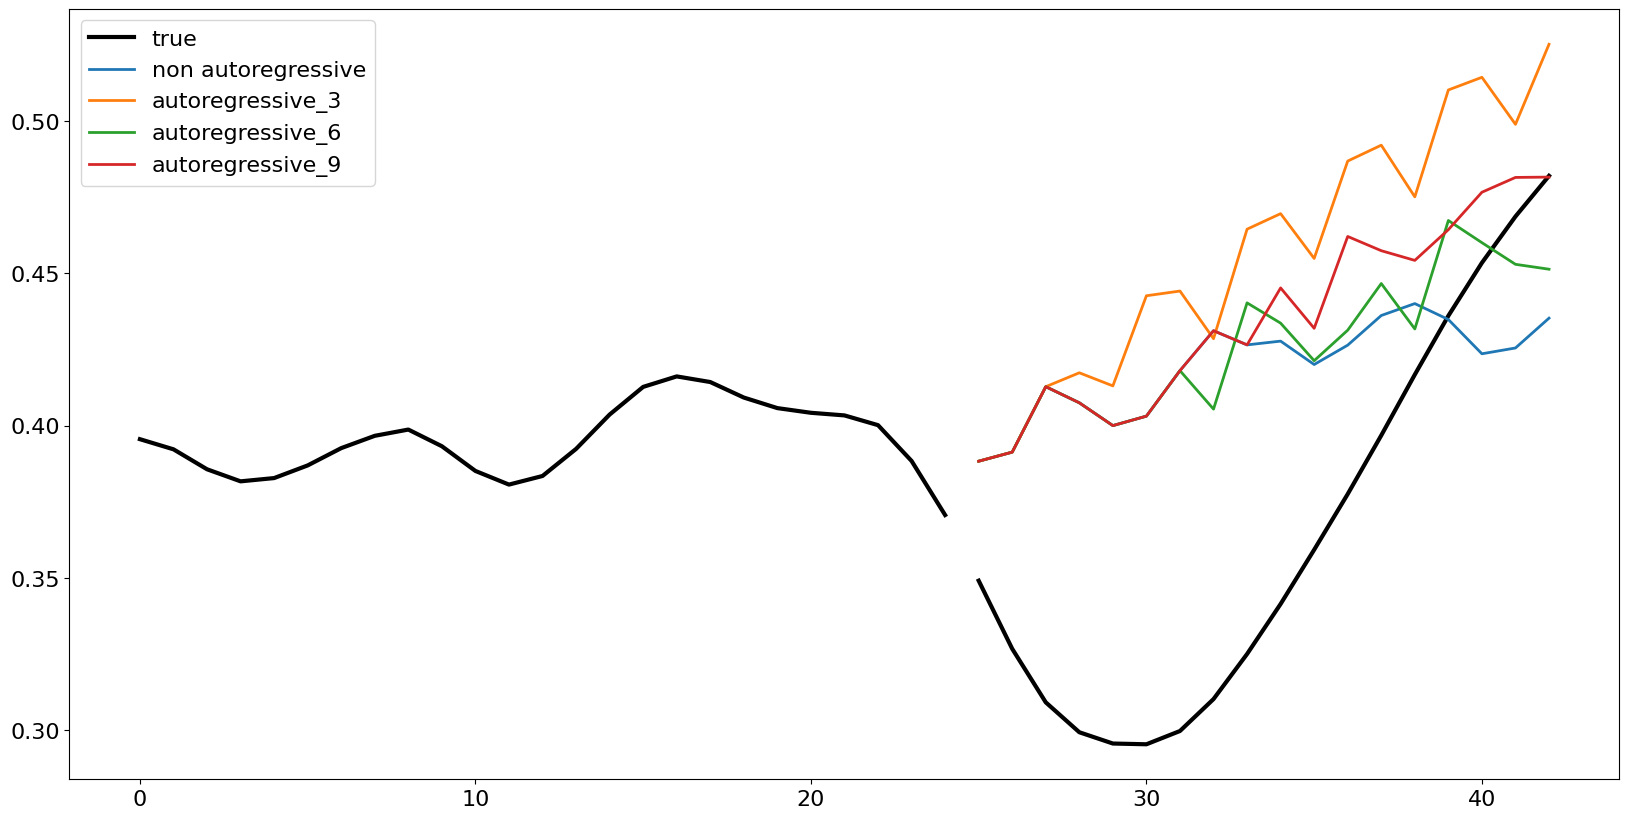

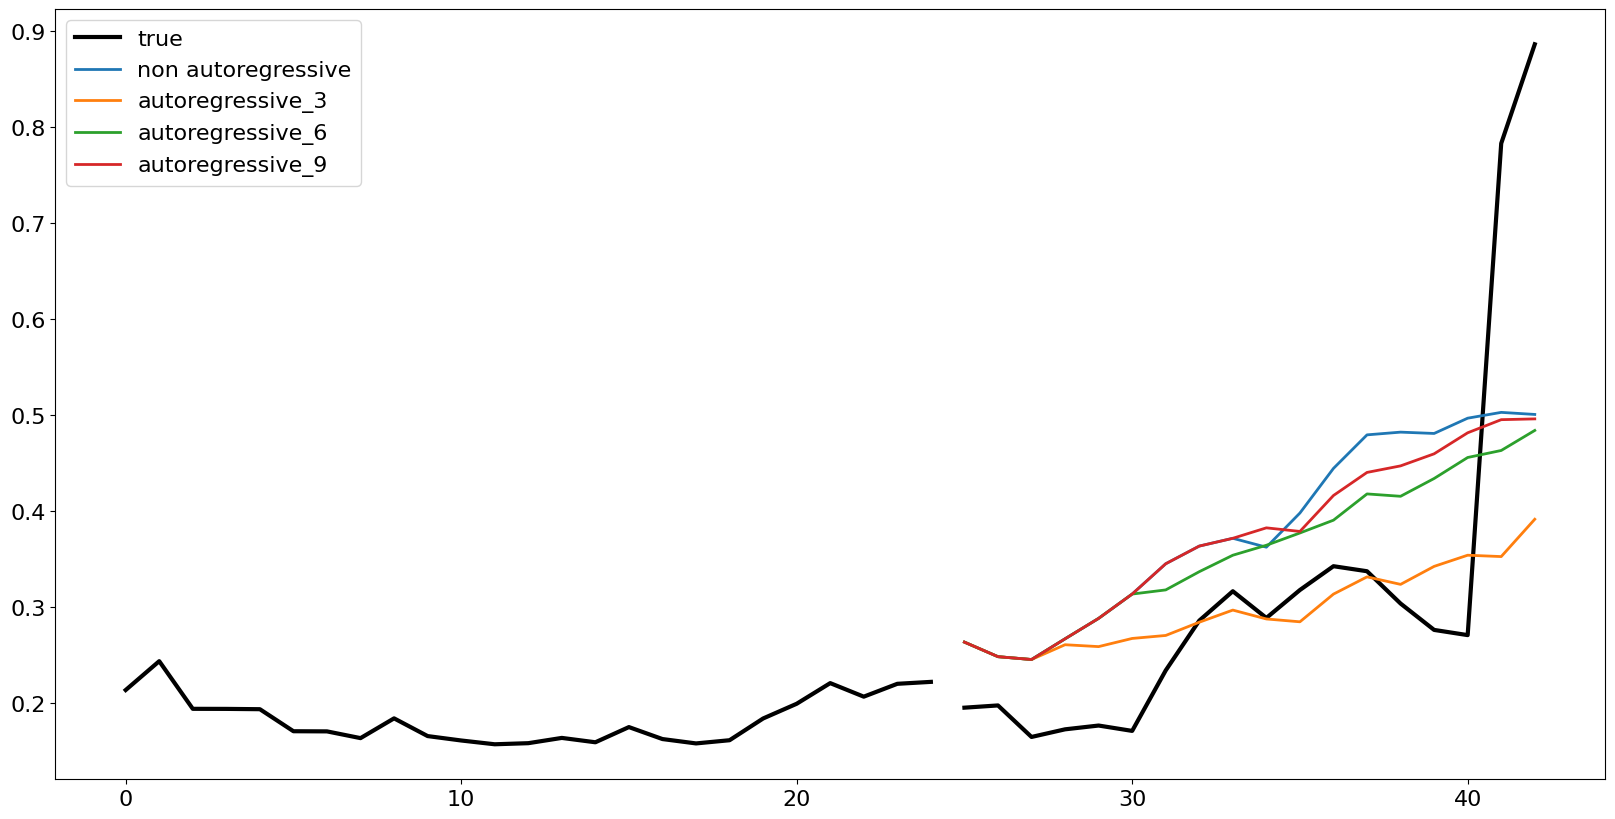

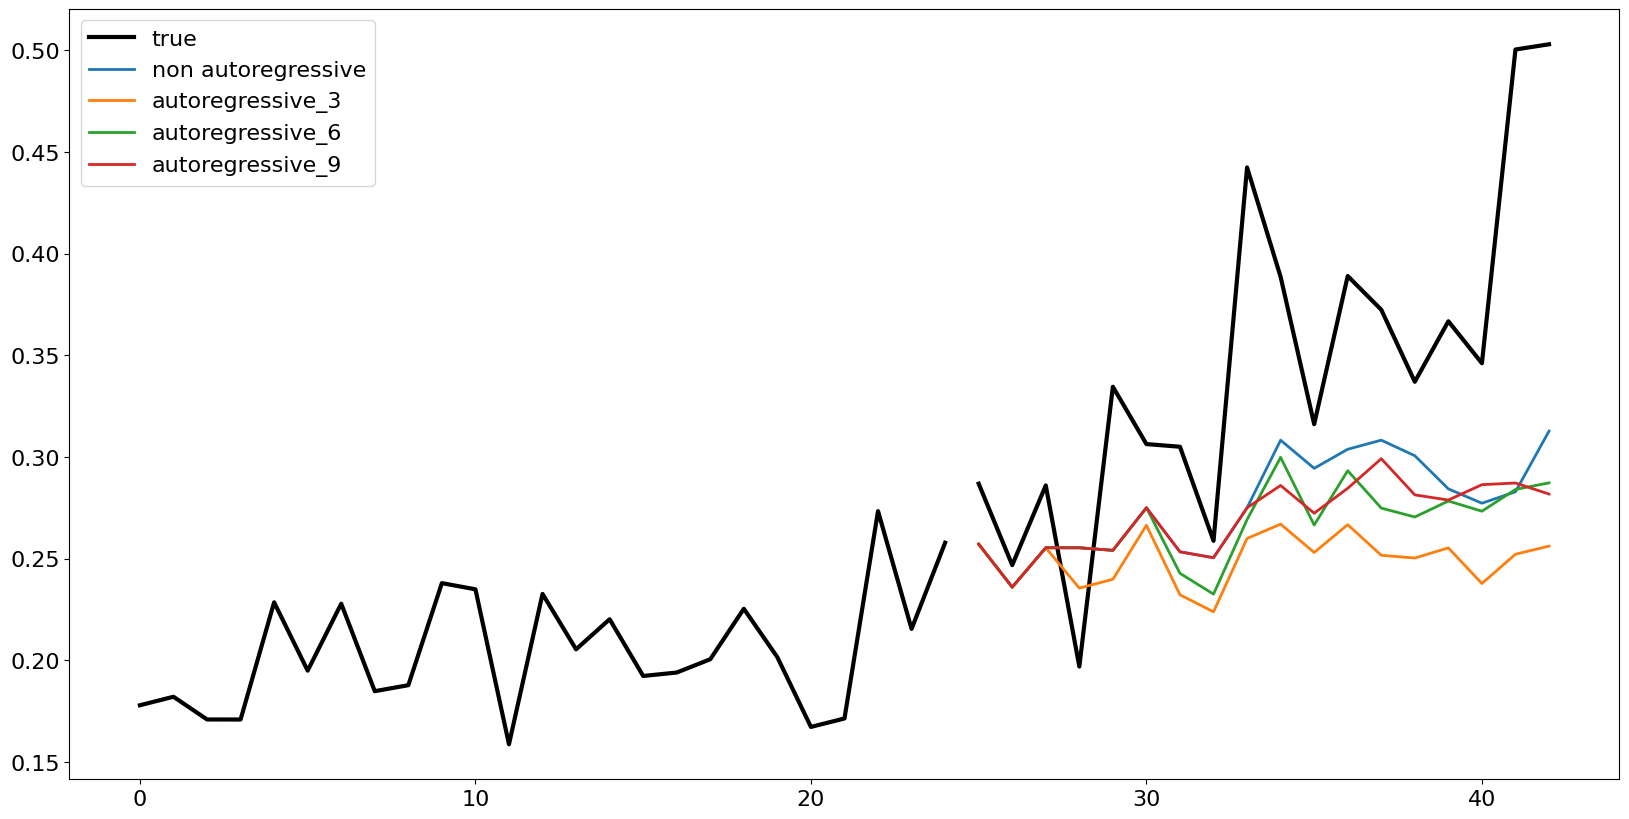

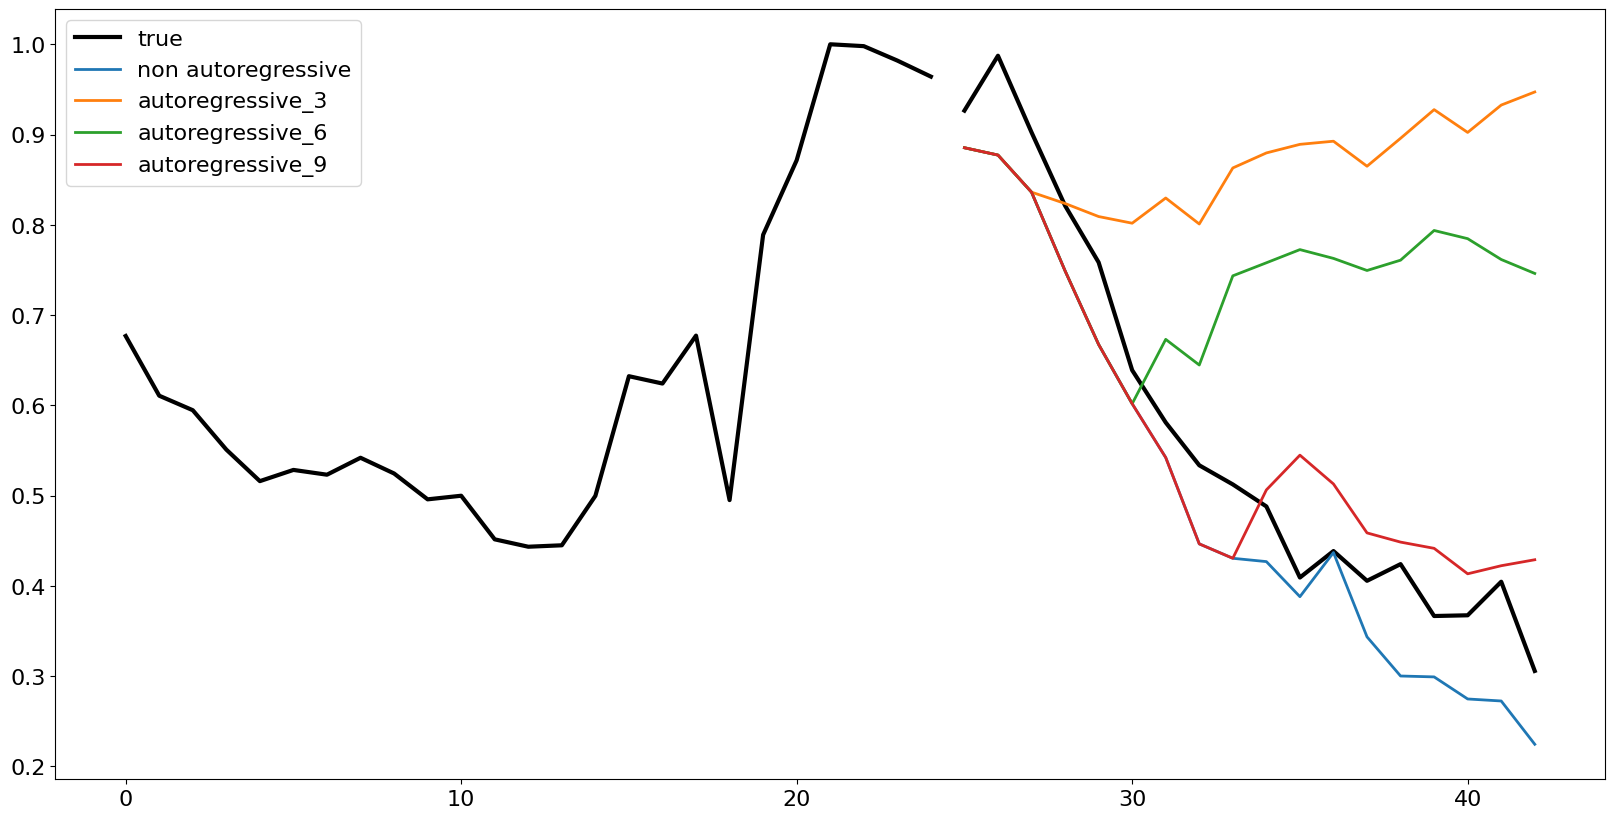

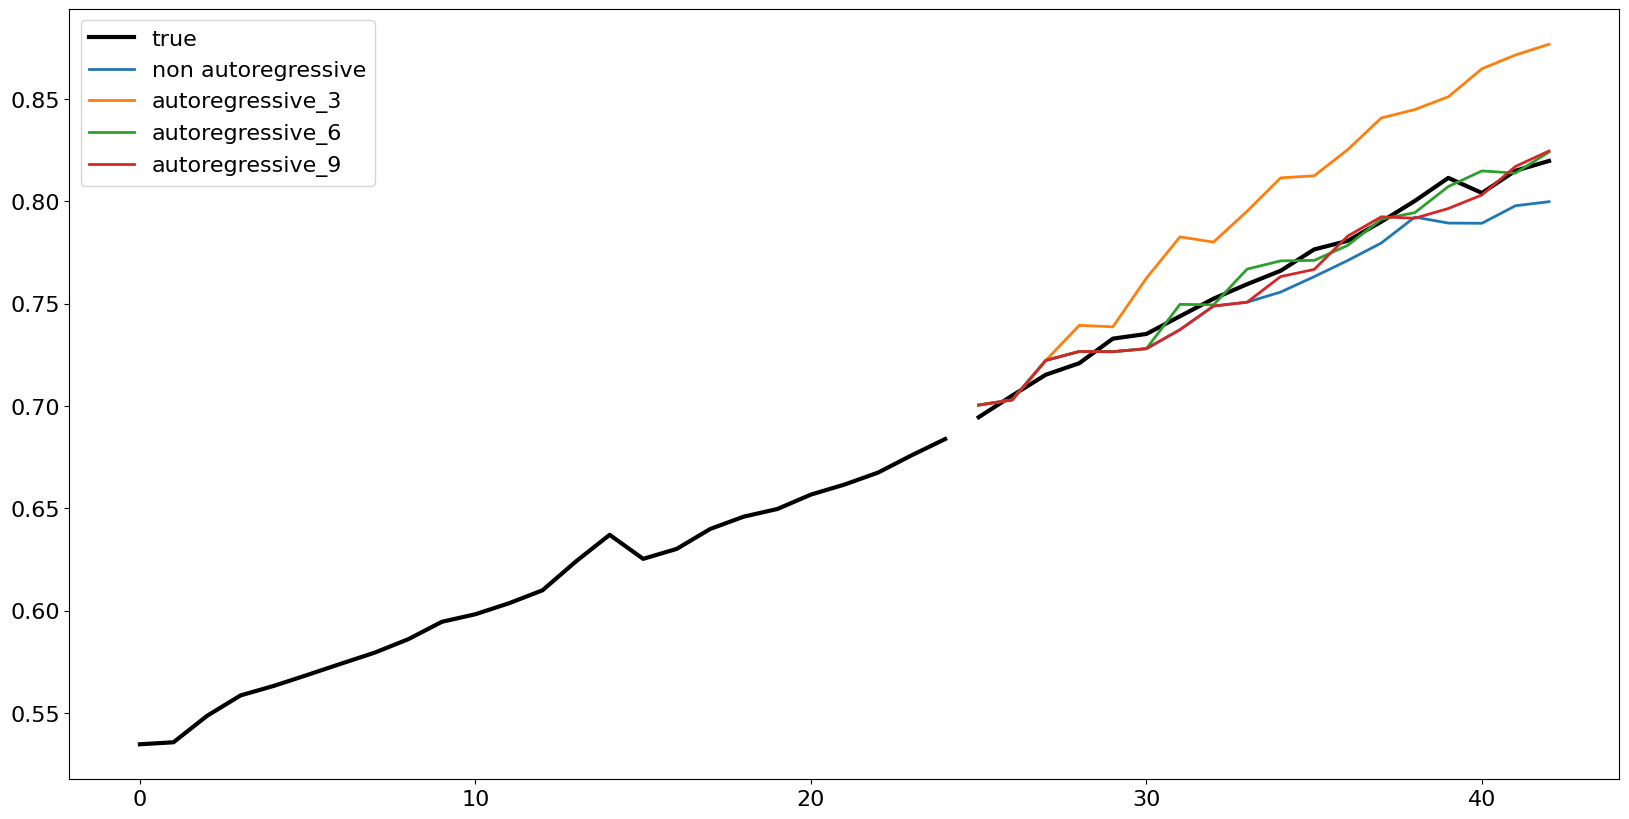

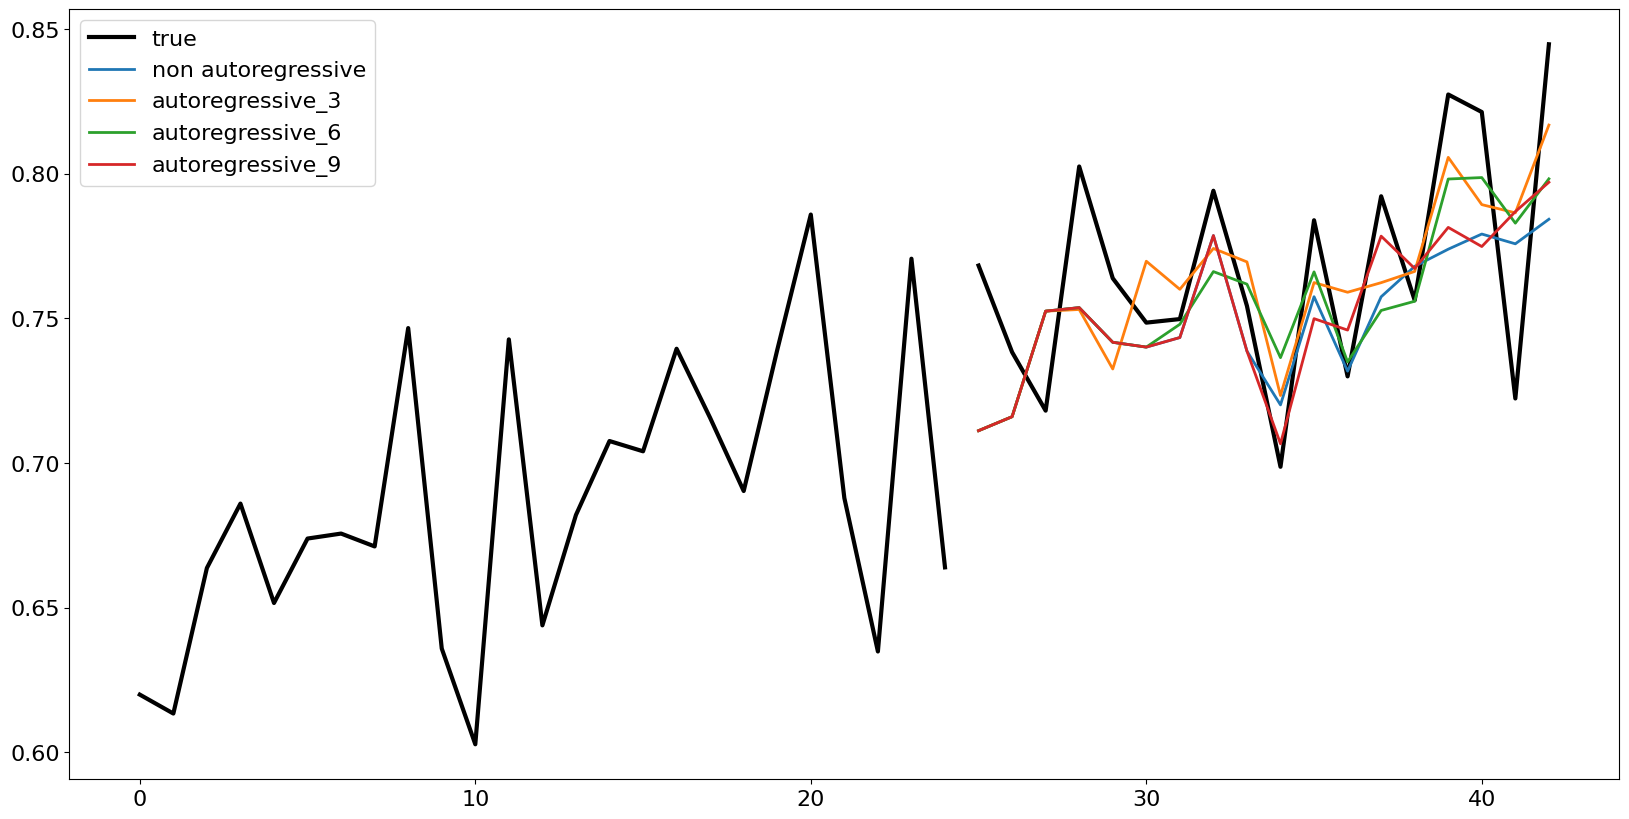

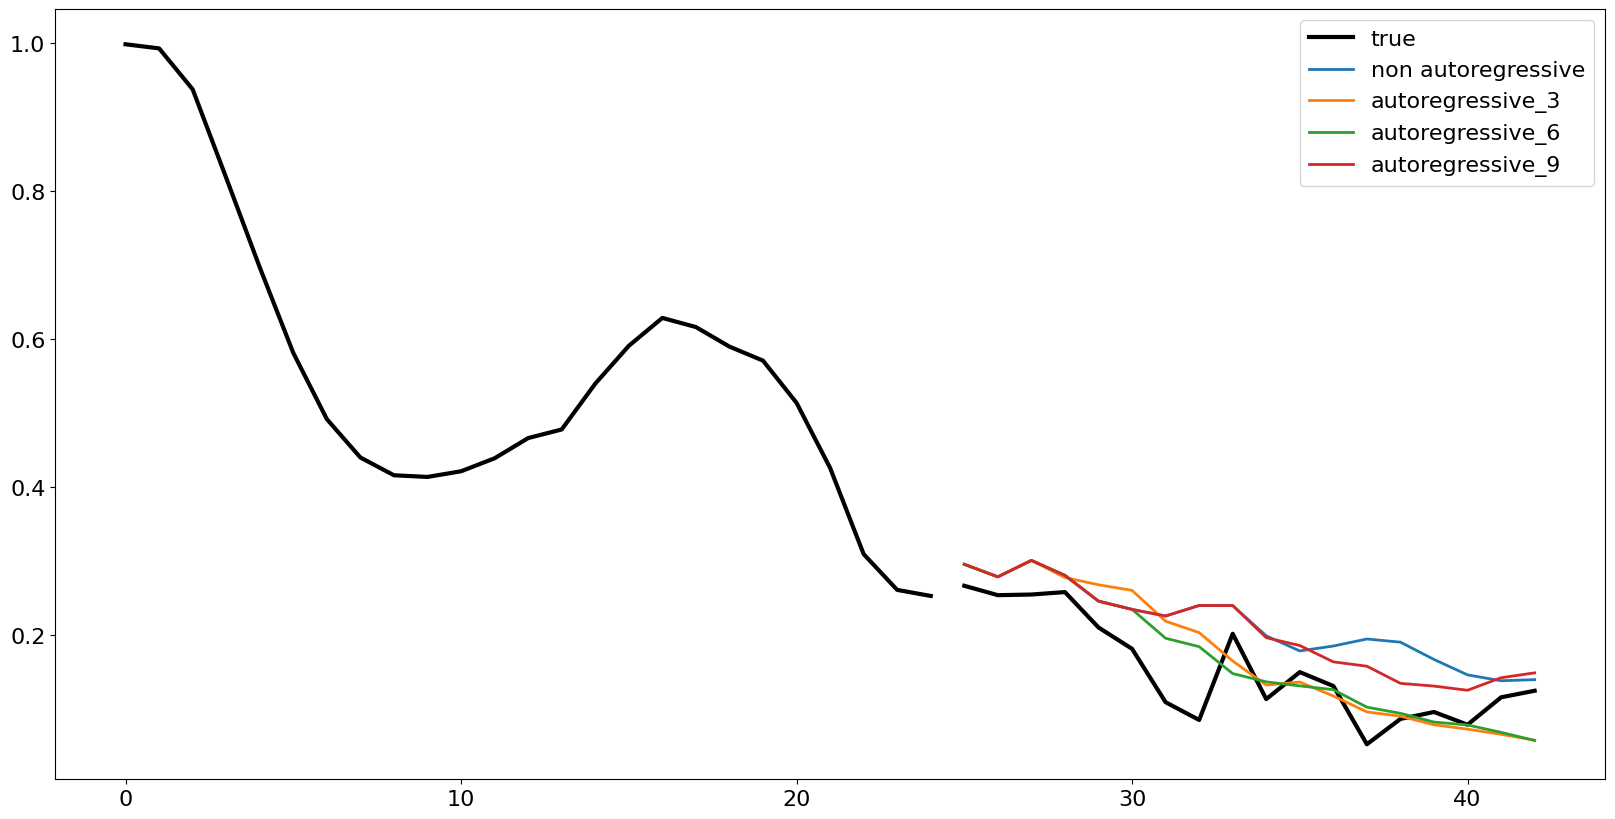

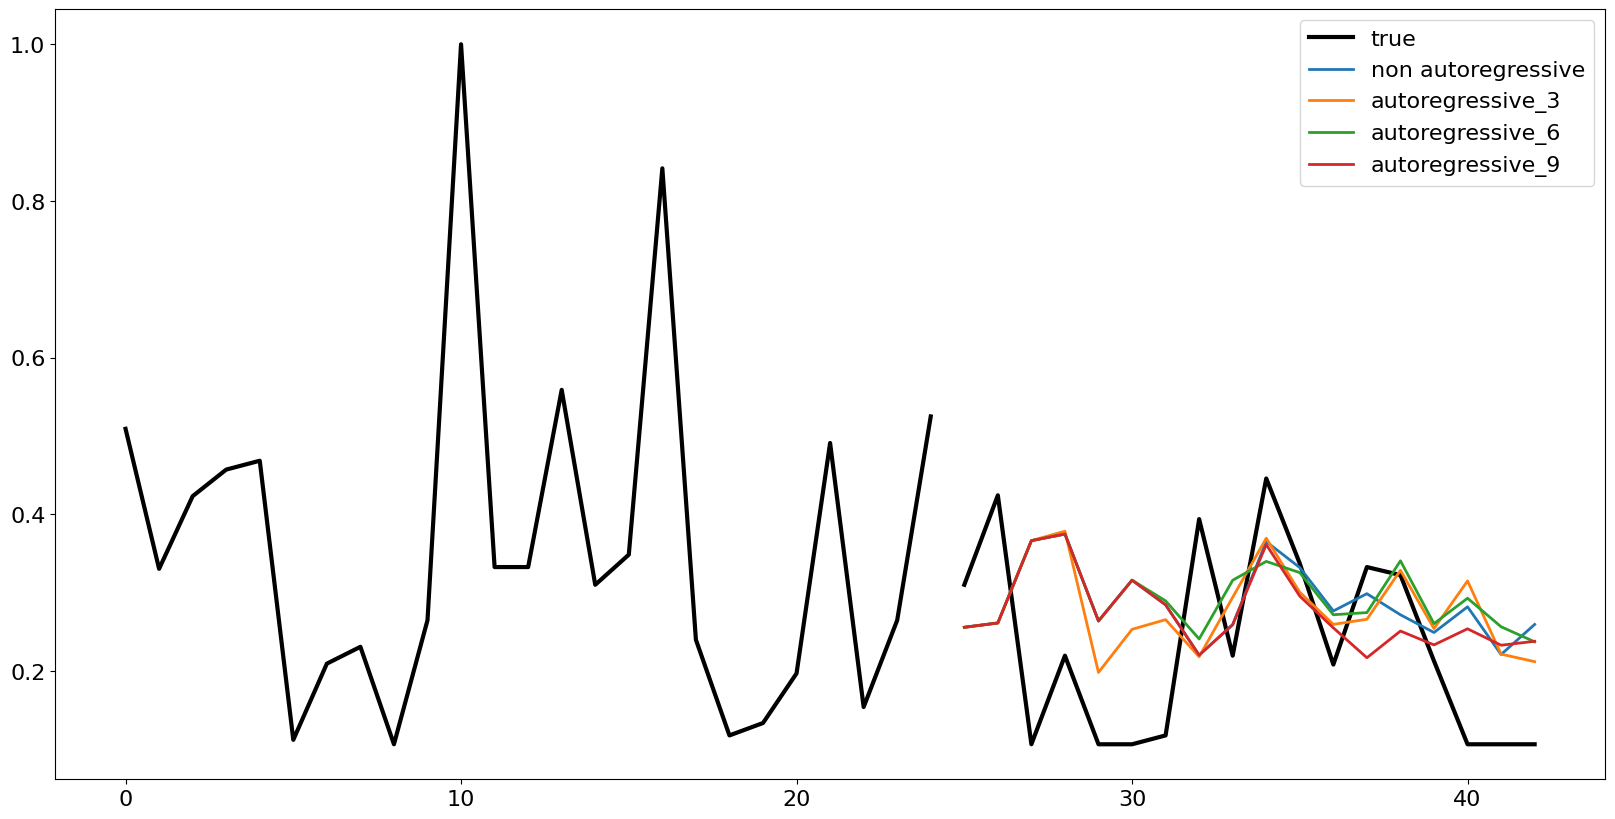

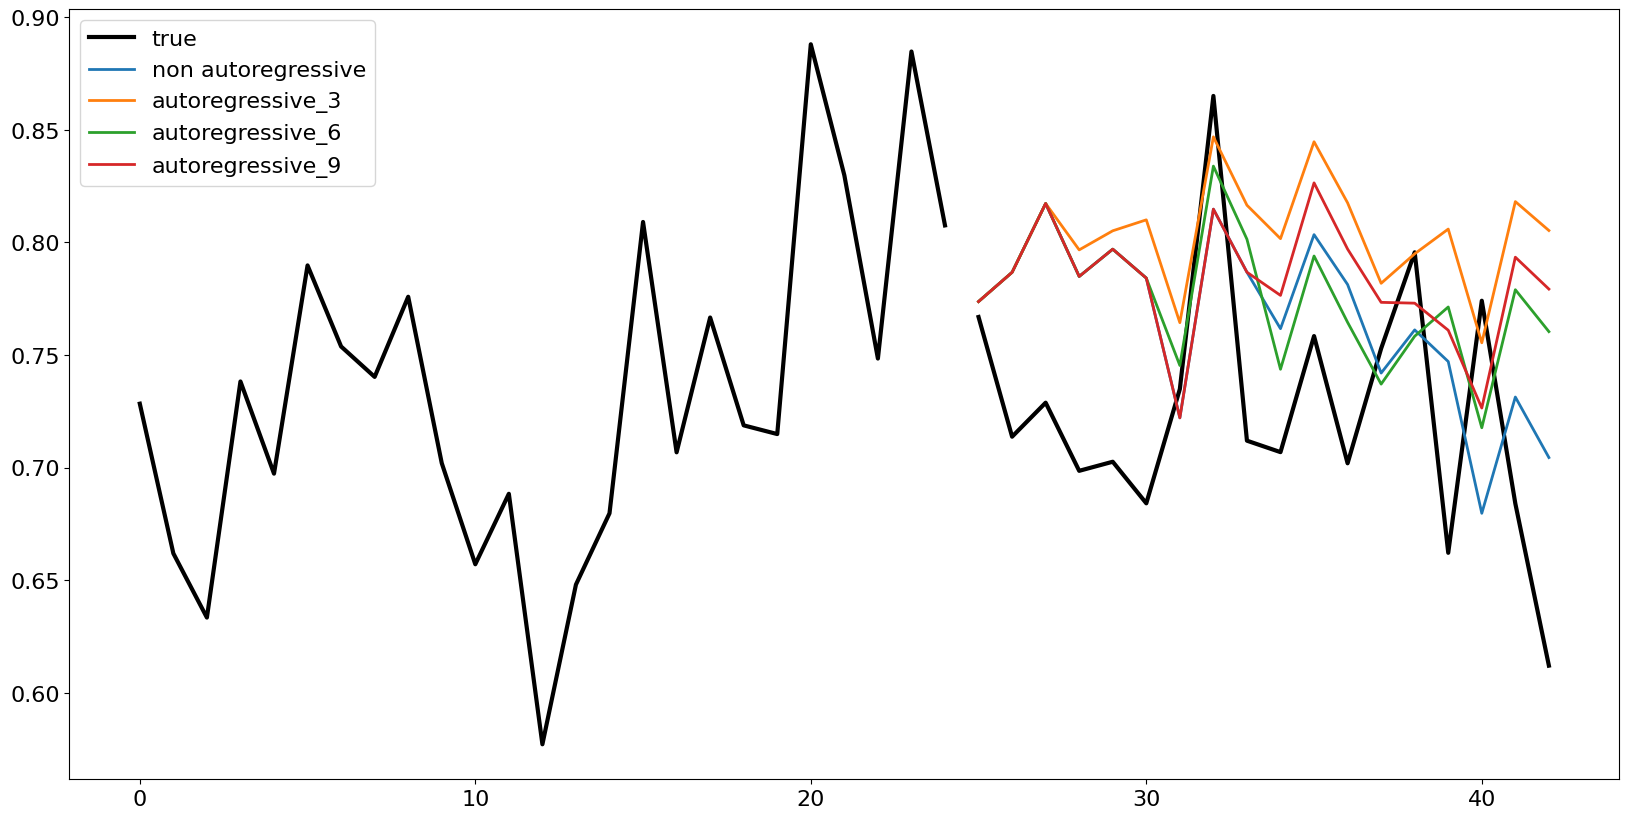

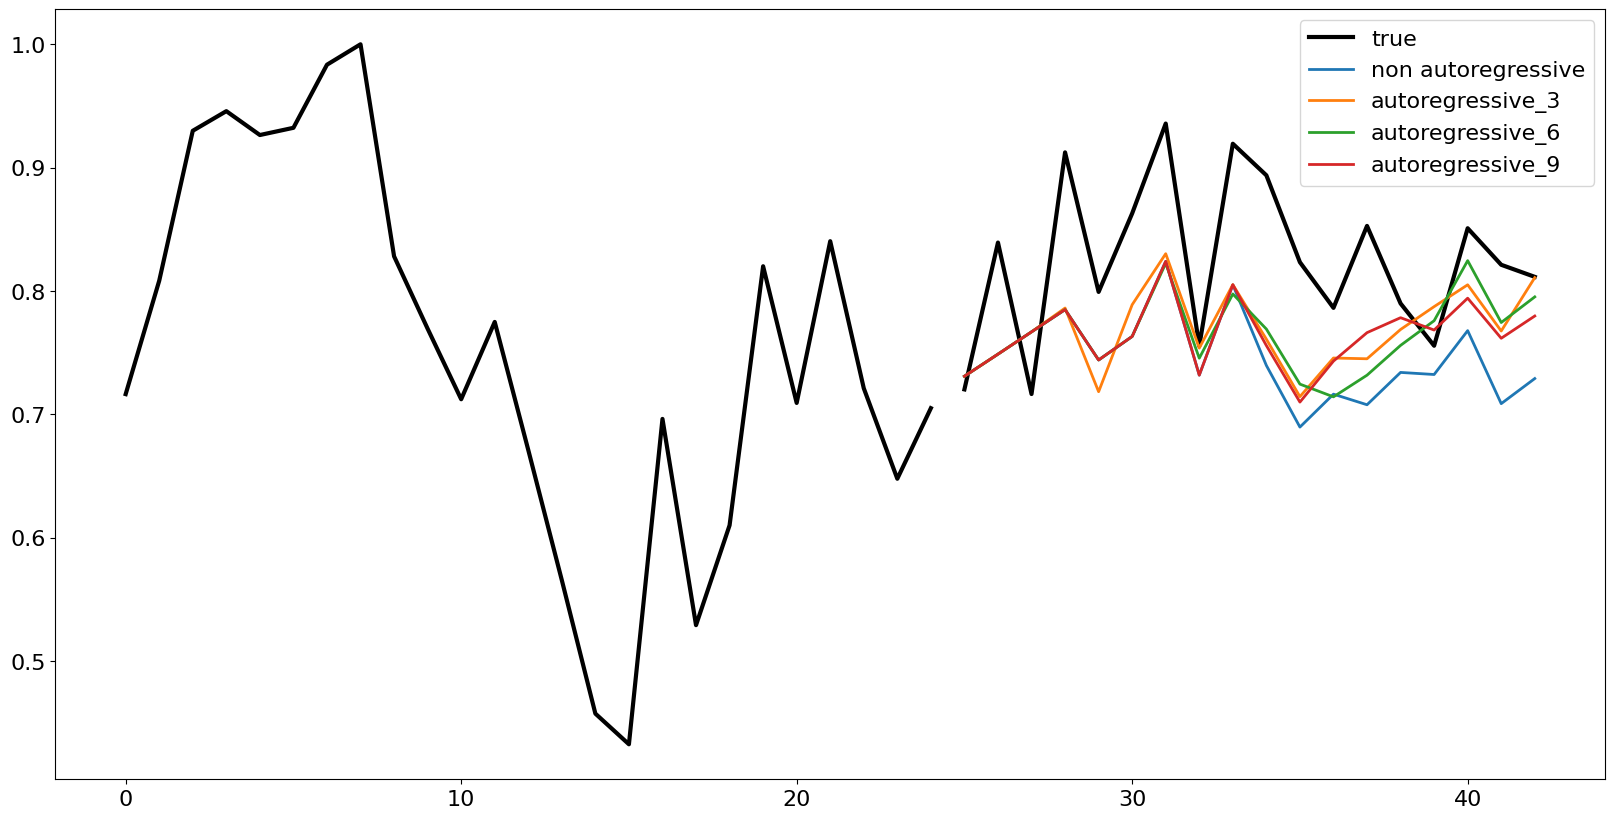

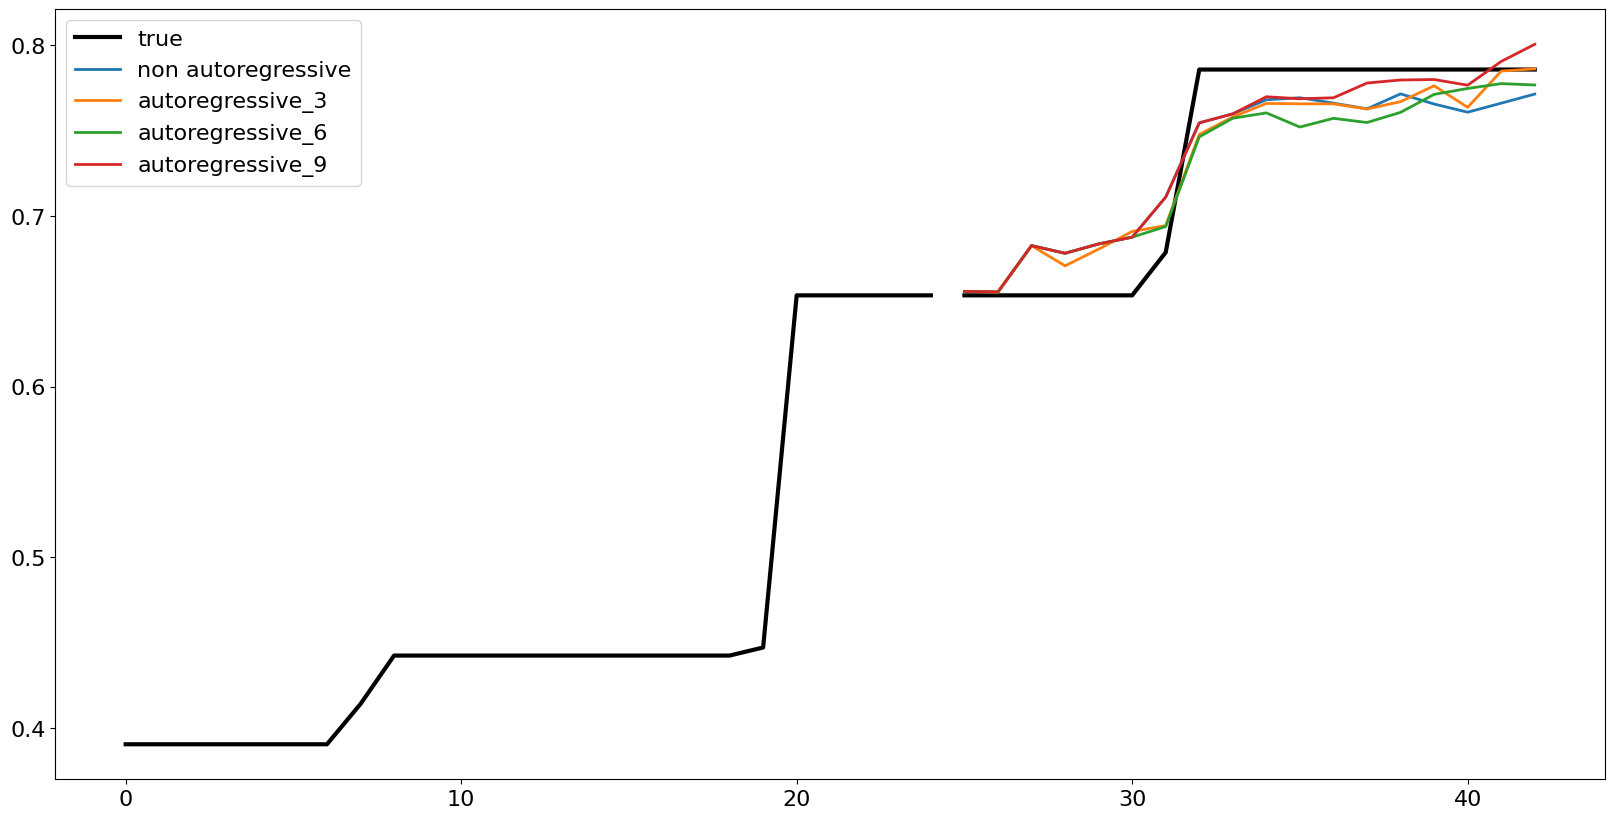

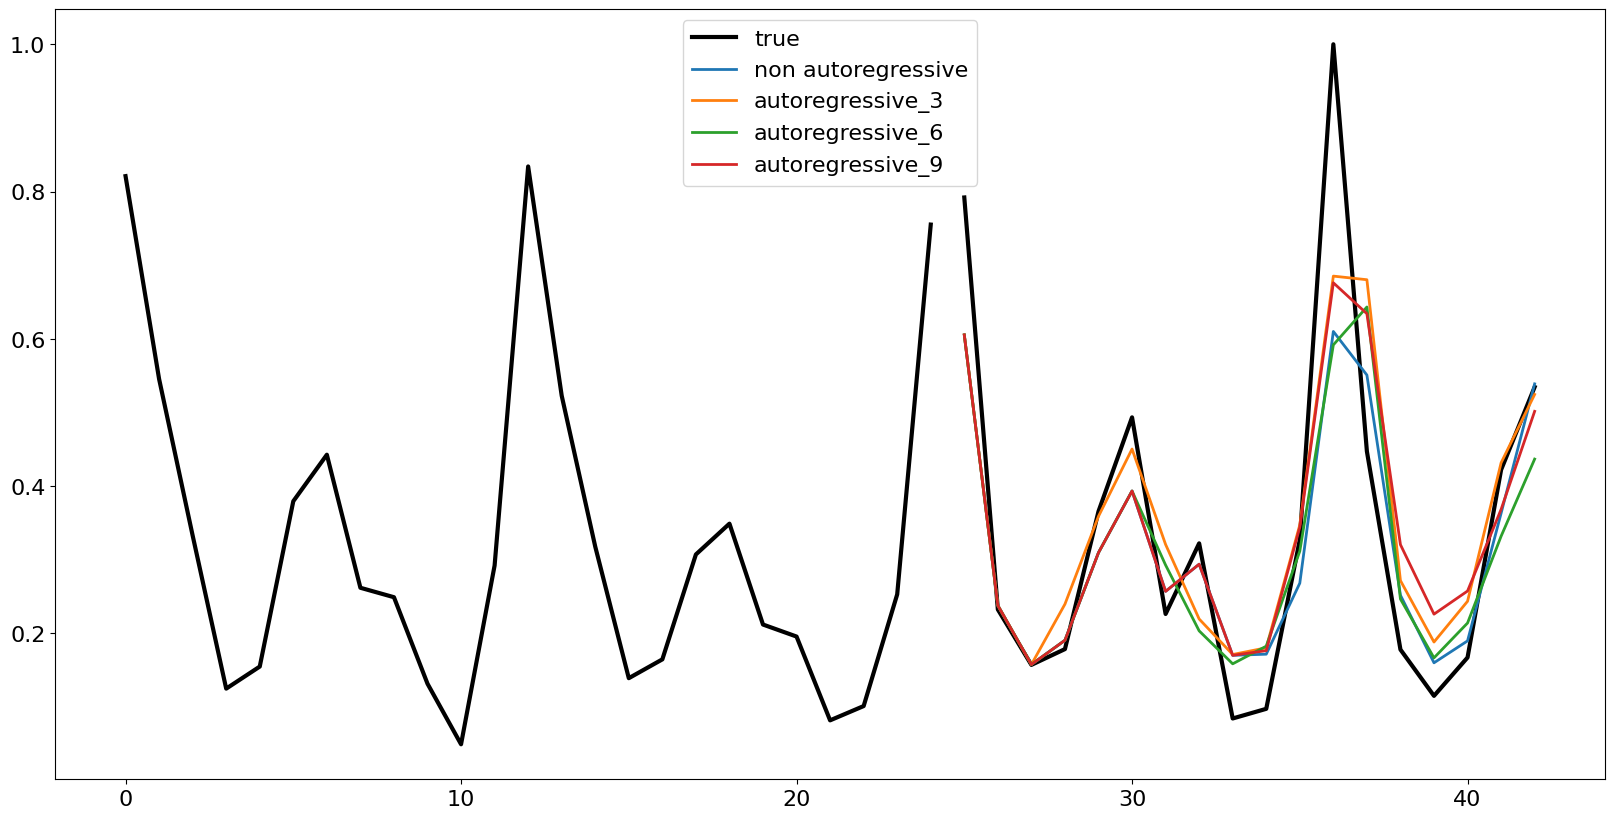

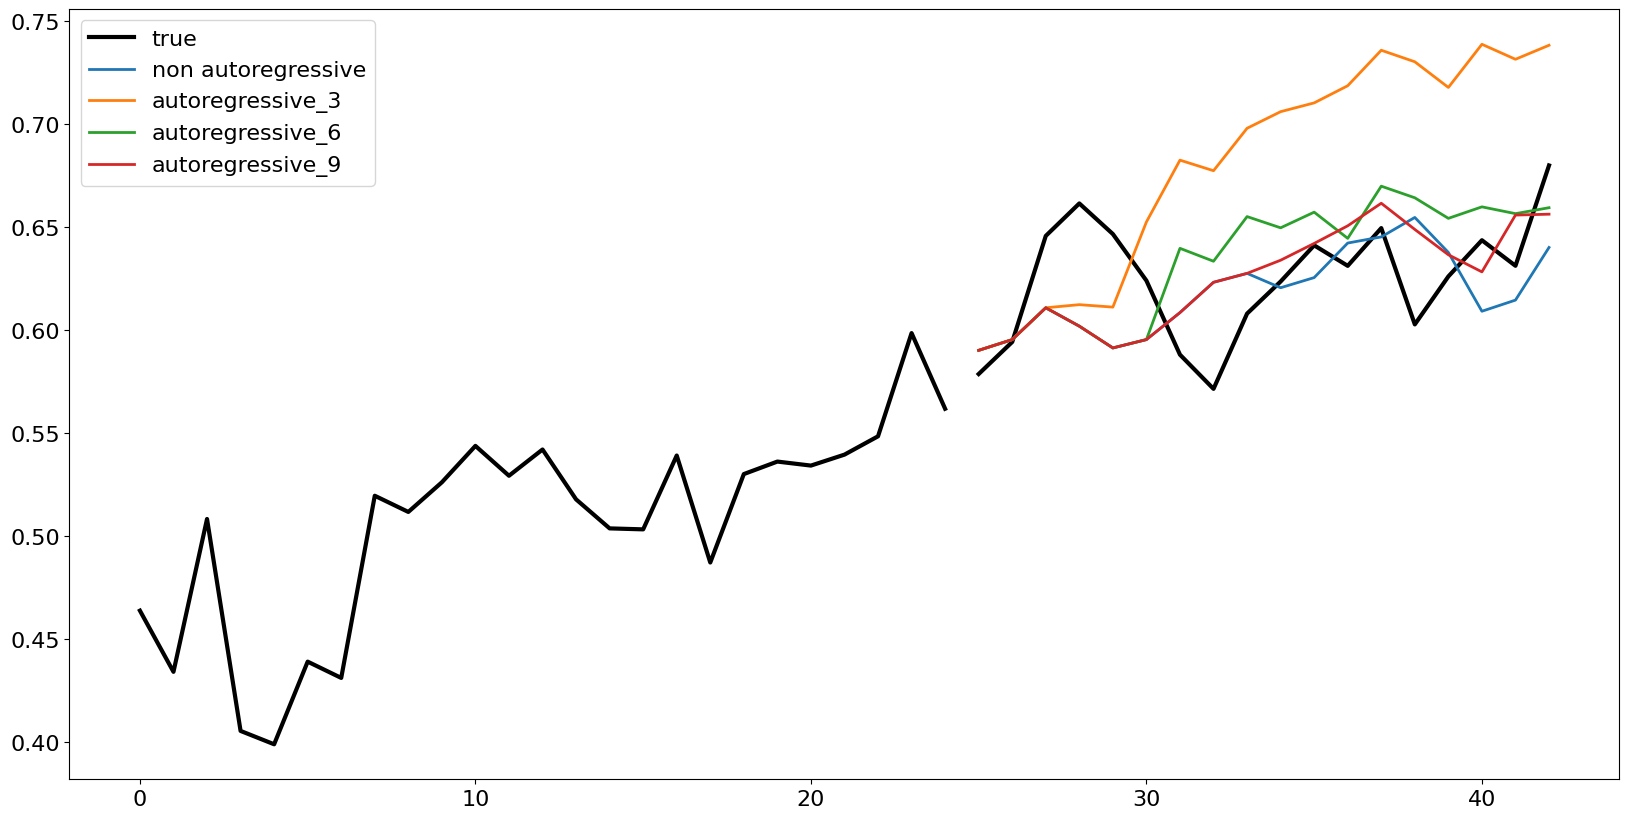

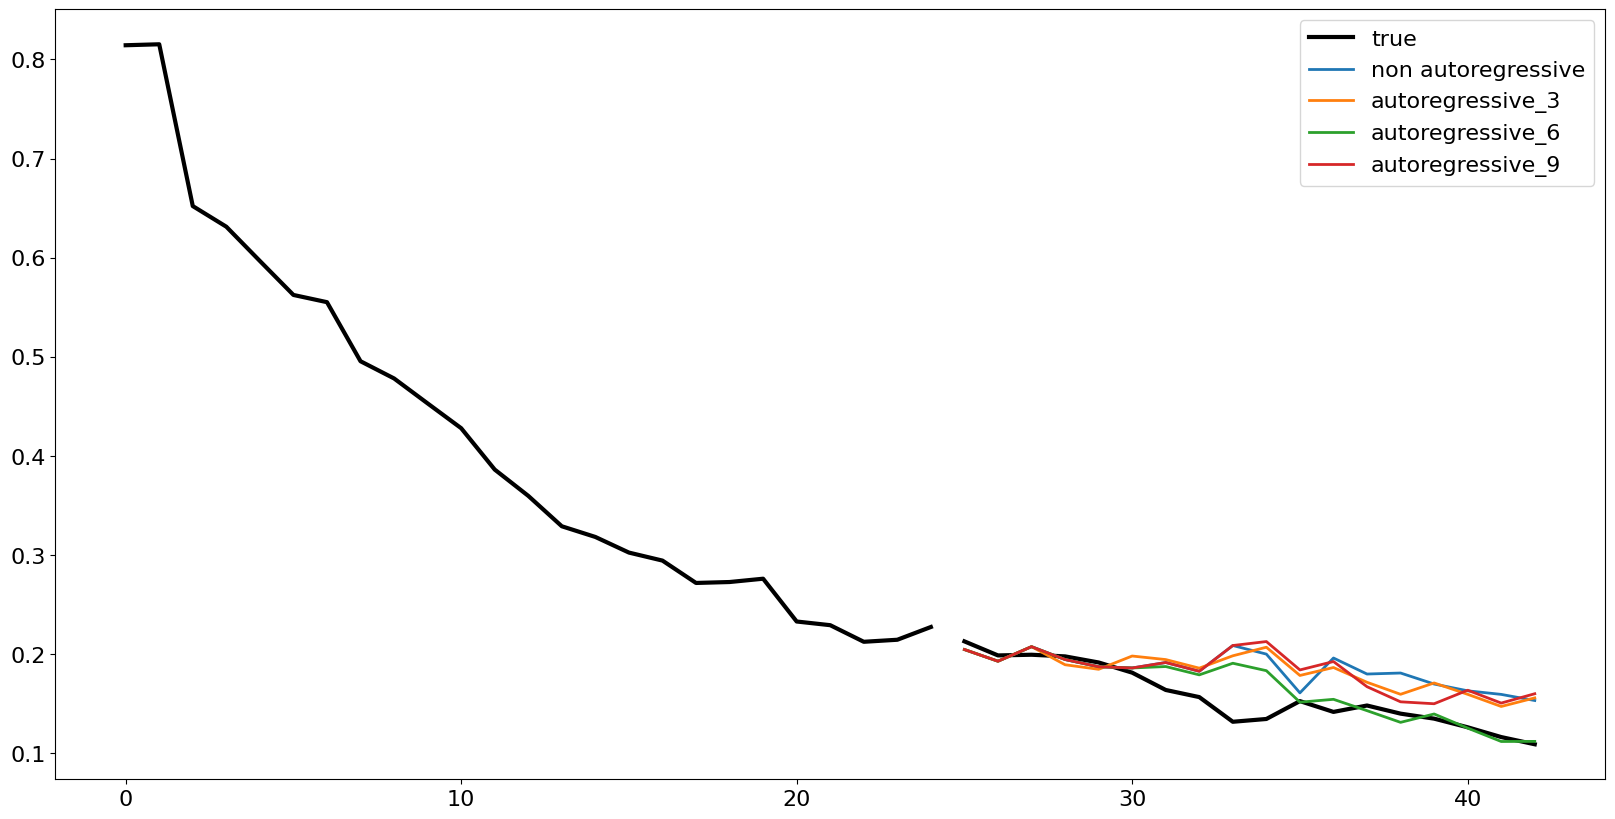

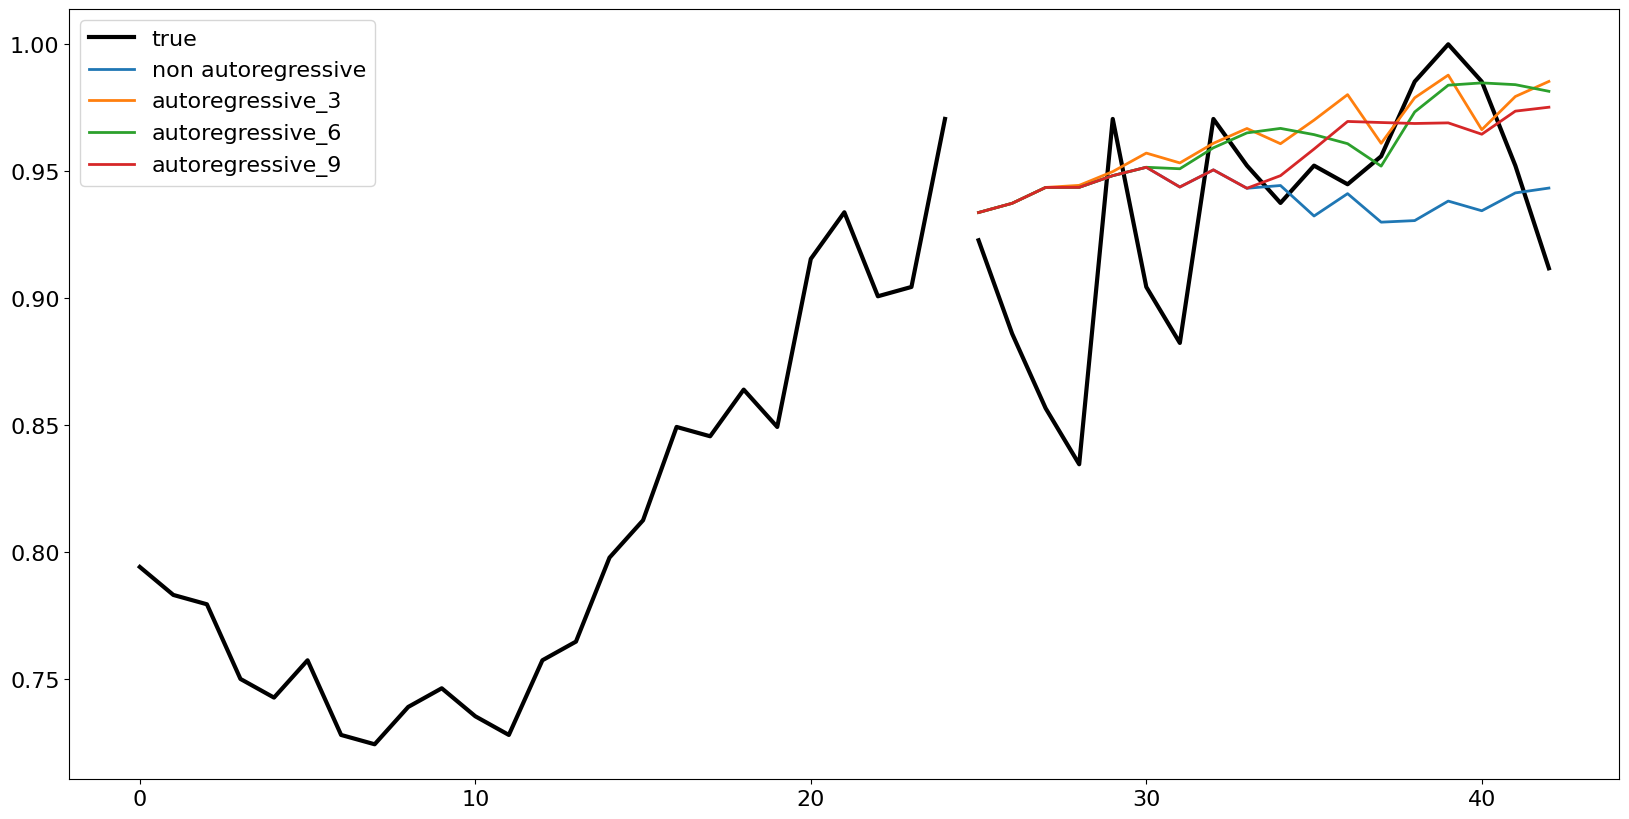

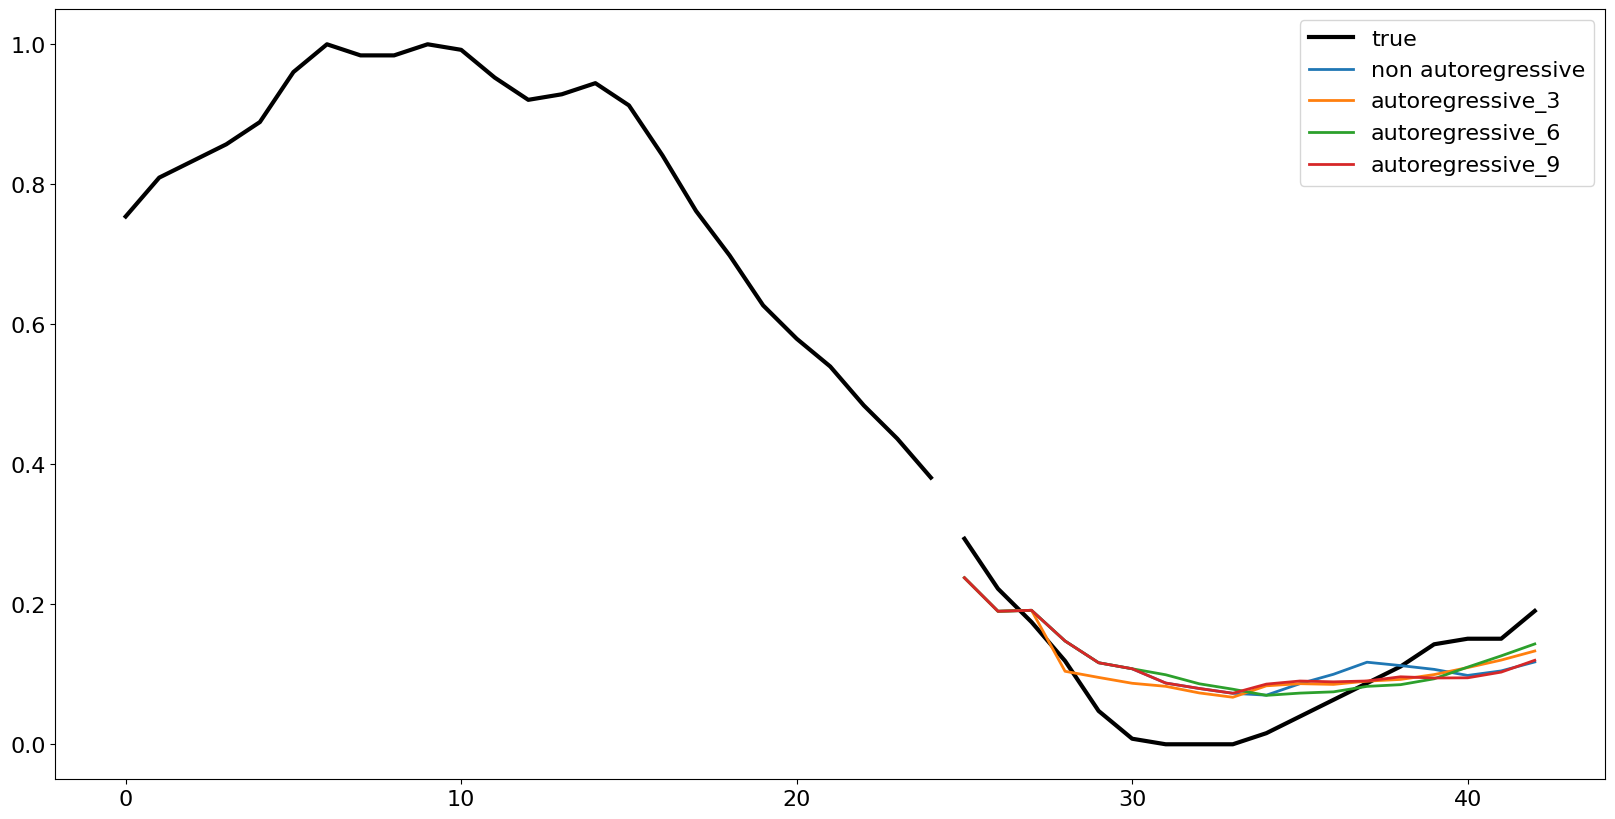

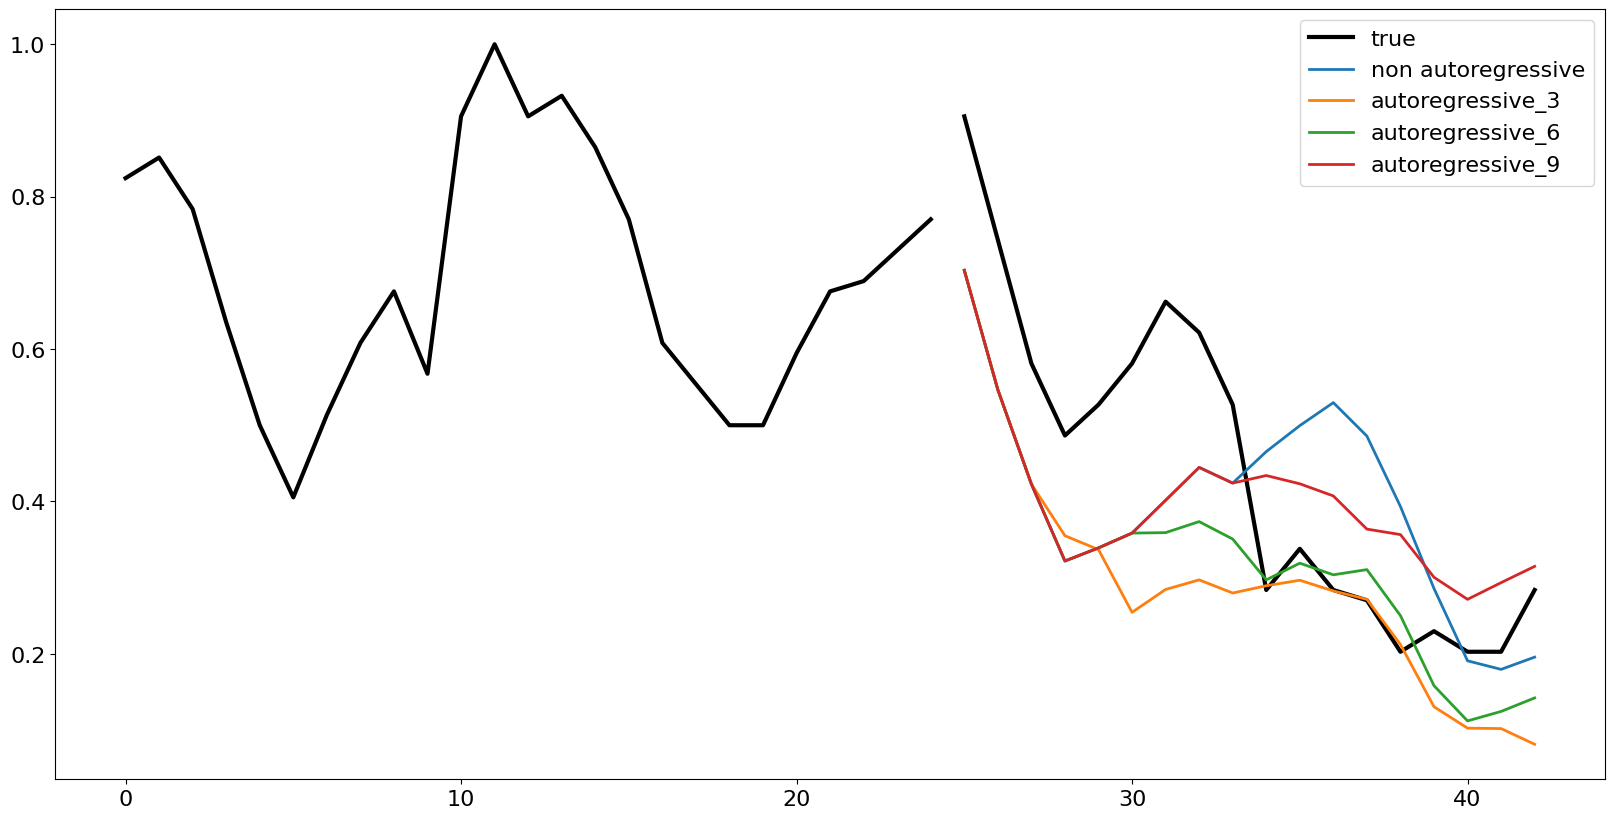

In [29]:
# plot some autoregressive vs non autoregressive
from C2.notebooks.Utils import plot_predictions
for i in range(20):
    l = 25
    i = np.random.randint(0, len(dataset))
    prev_data = dataset[i, -l:]
    plt.figure(figsize=(20, 10))
    plt.plot(range(l), prev_data, color='black', linewidth=3)
    plt.plot(range(l,l+18), labels[i], label='true', color='black', linewidth=3)
    plt.plot(range(l,l+18), predictions_all[i, :, 0], label='non autoregressive', linewidth=2)
    plt.plot(range(l,l+18), predictions_all[i , :, len(models)], label='autoregressive_3', linewidth=2)
    plt.plot(range(l,l+18), predictions_all[i , :, len(models)*2], label='autoregressive_6', linewidth=2)
    plt.plot(range(l,l+18), predictions_all[i , :, len(models)*3], label='autoregressive_9', linewidth=2)
    plt.legend()
    plt.show()
    

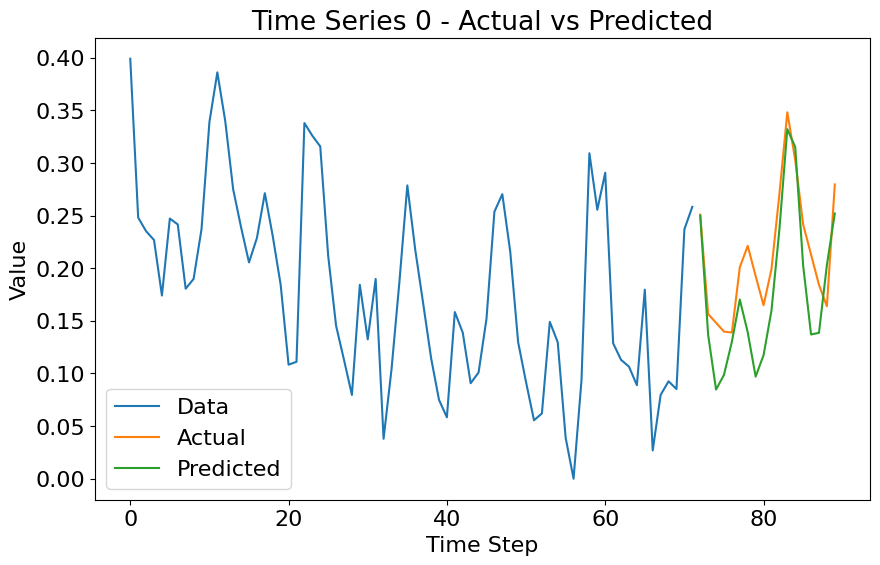

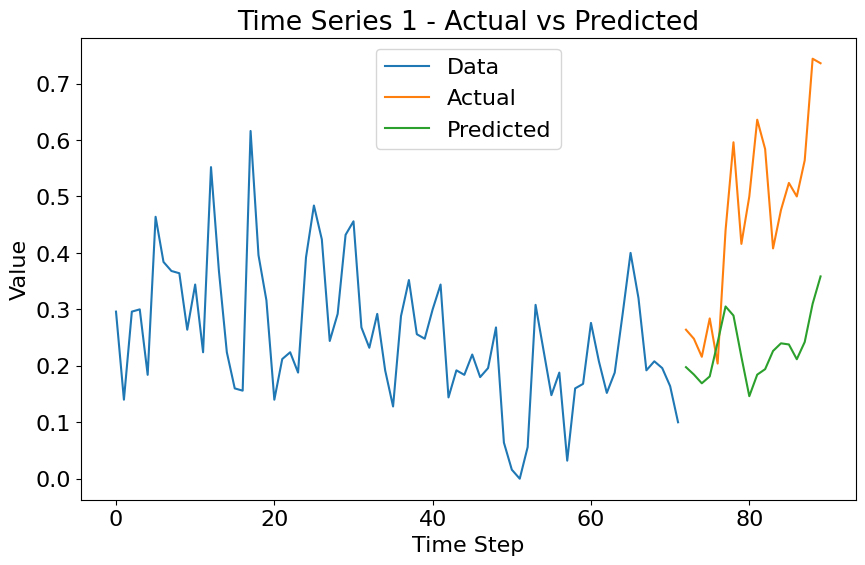

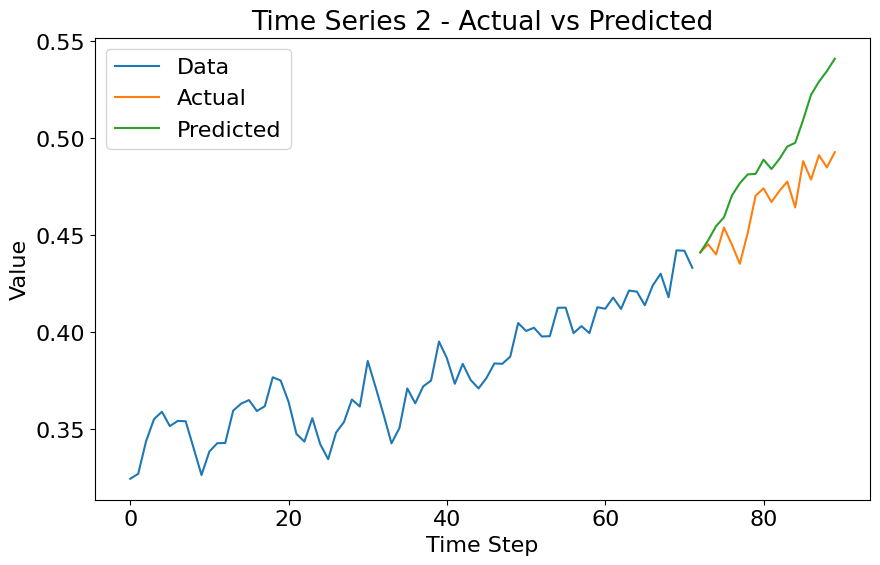

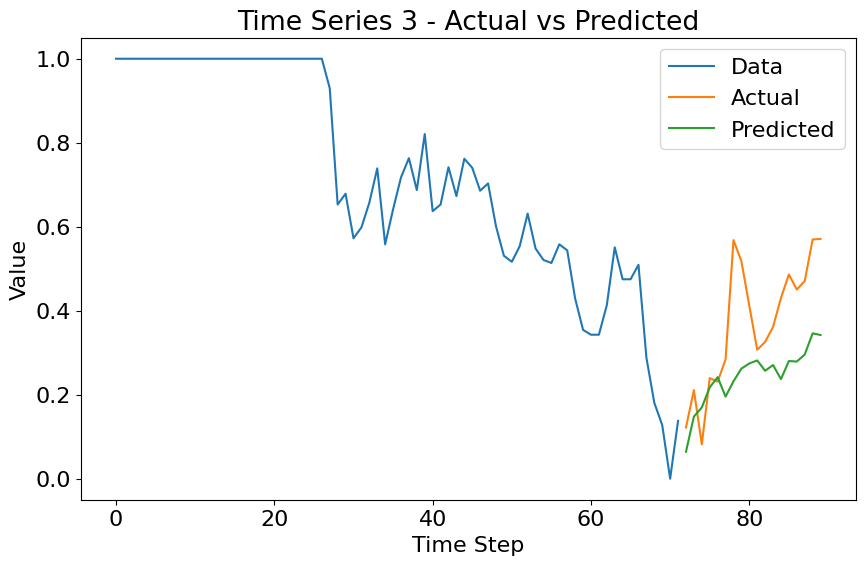

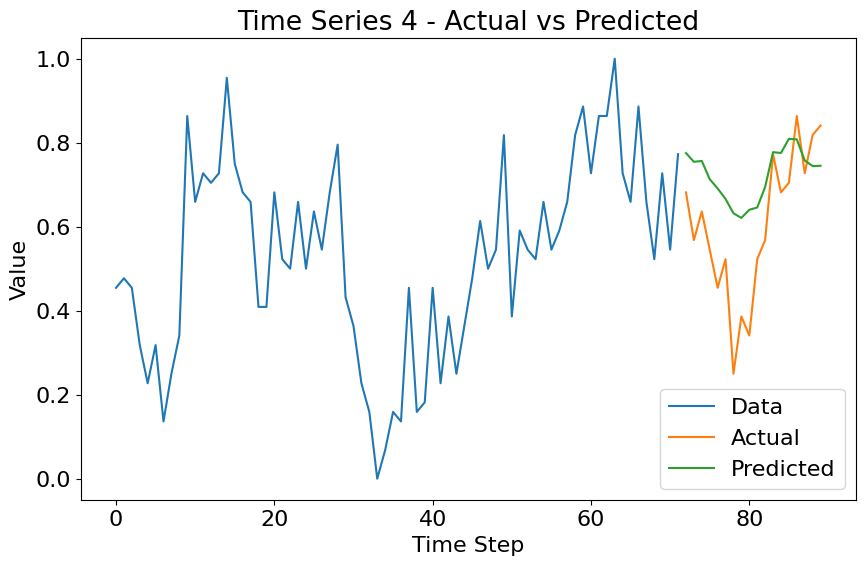

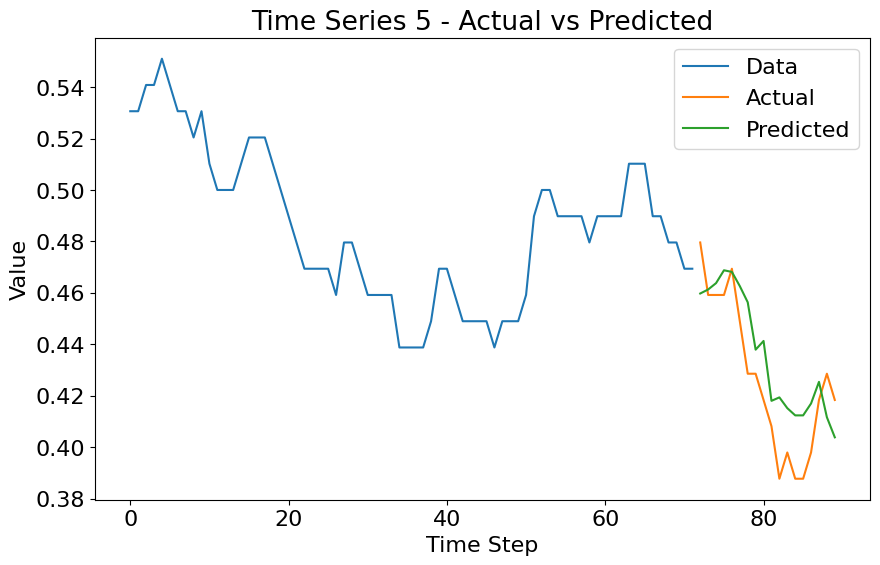

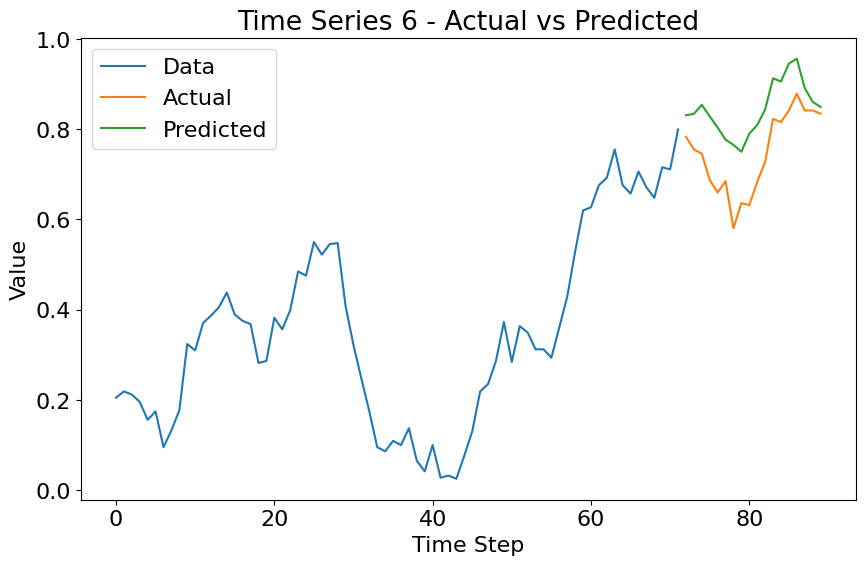

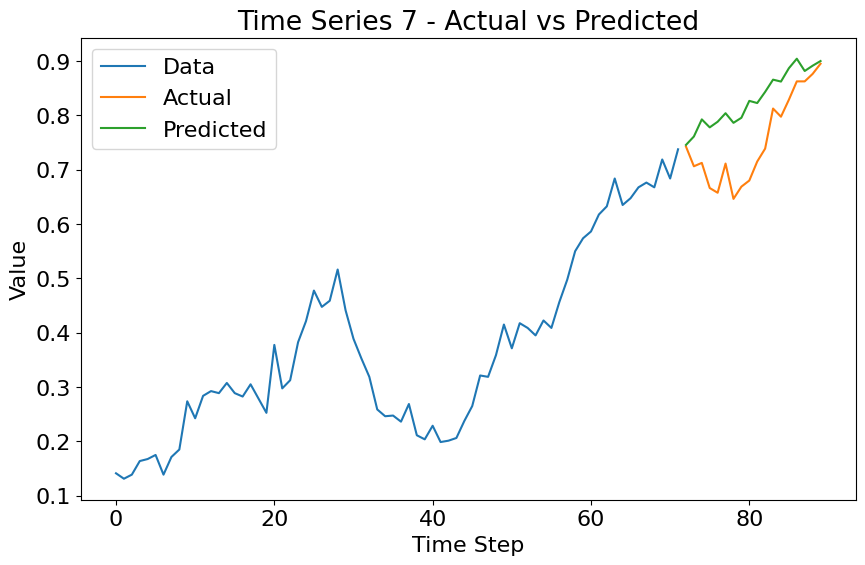

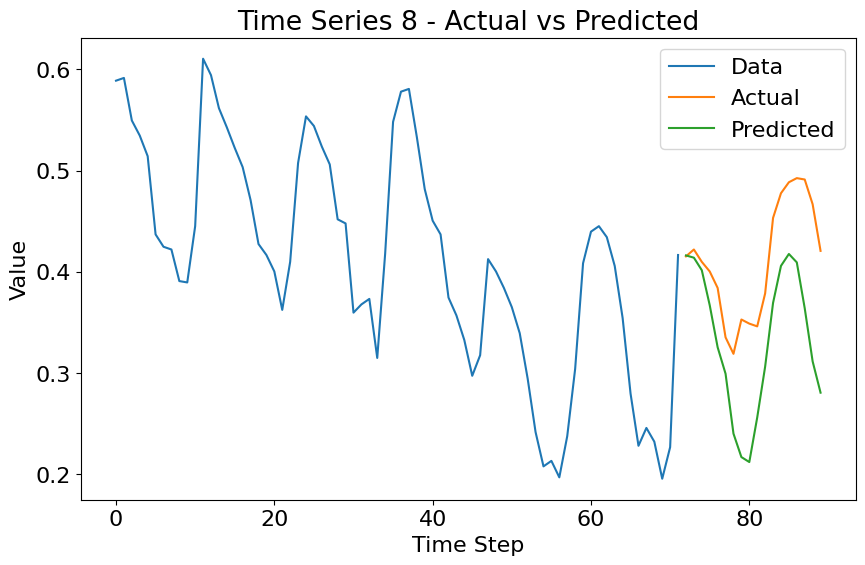

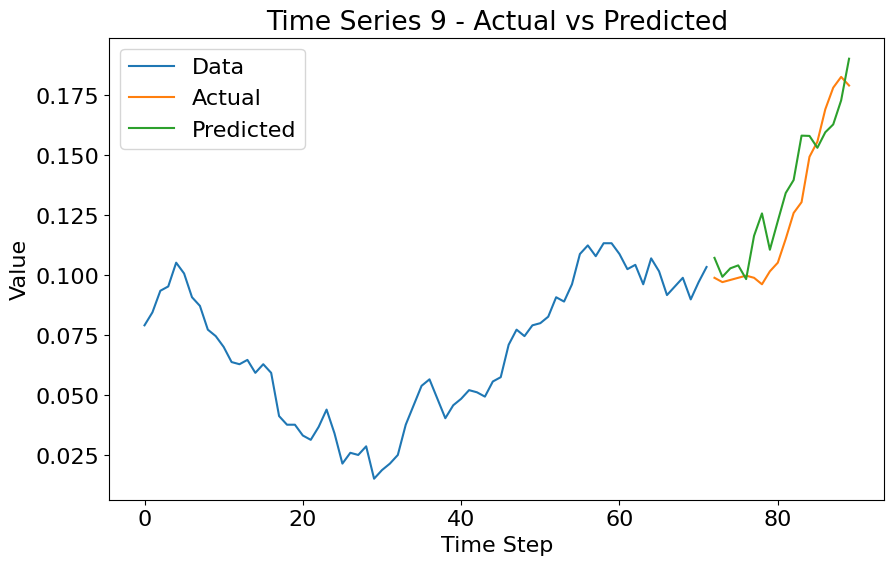

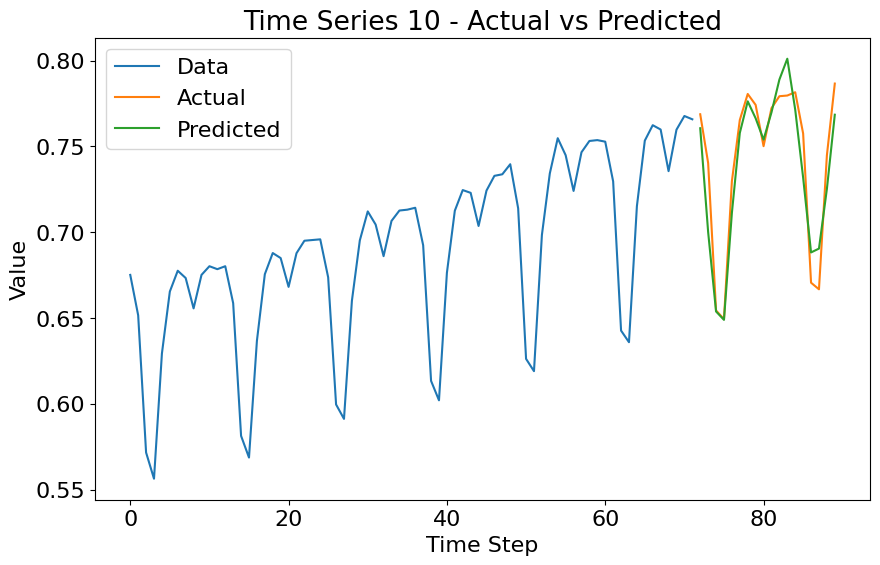

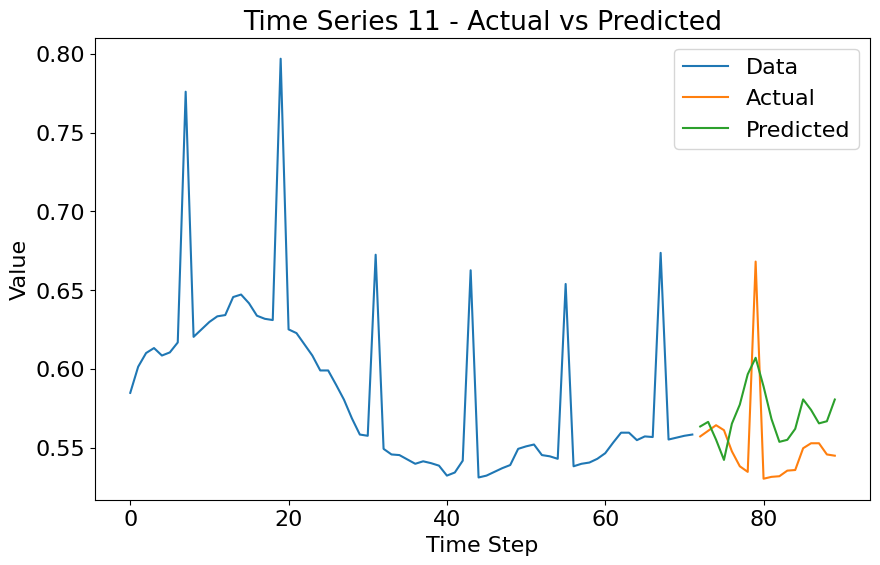

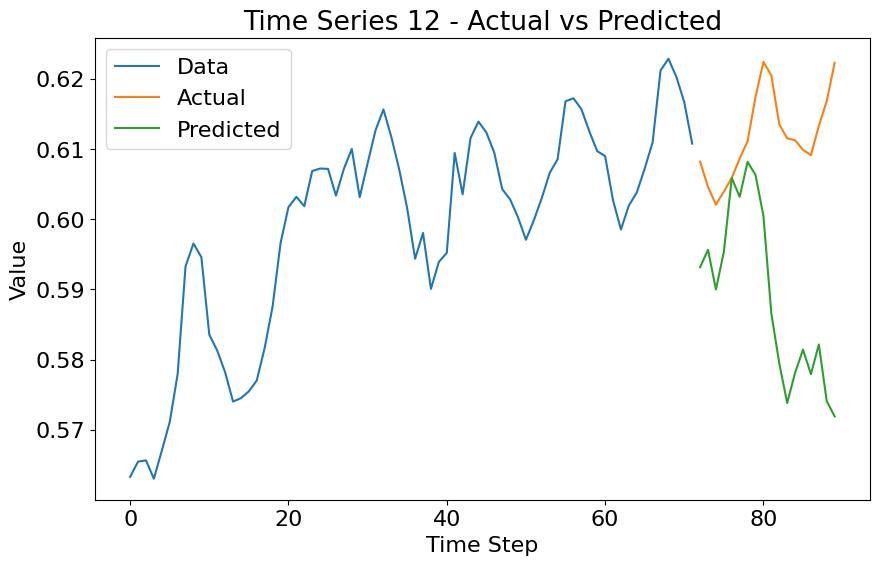

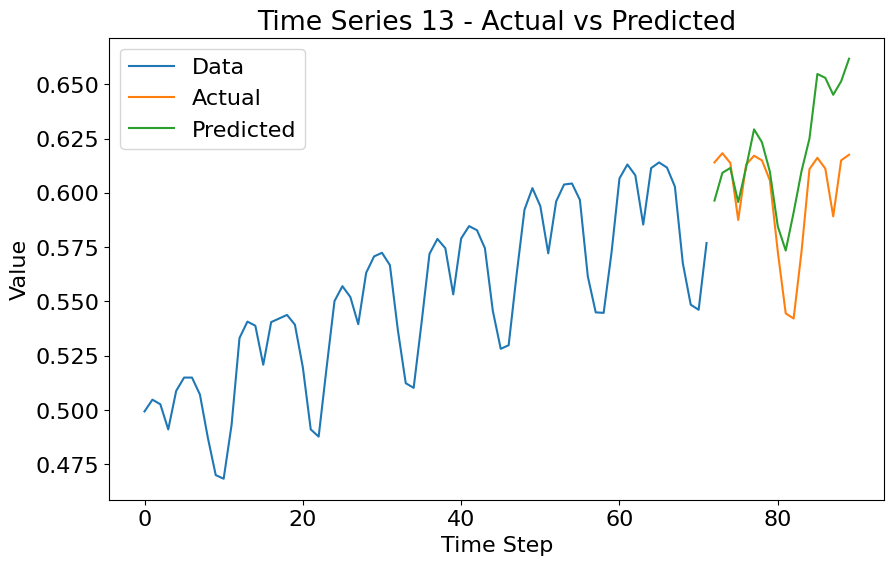

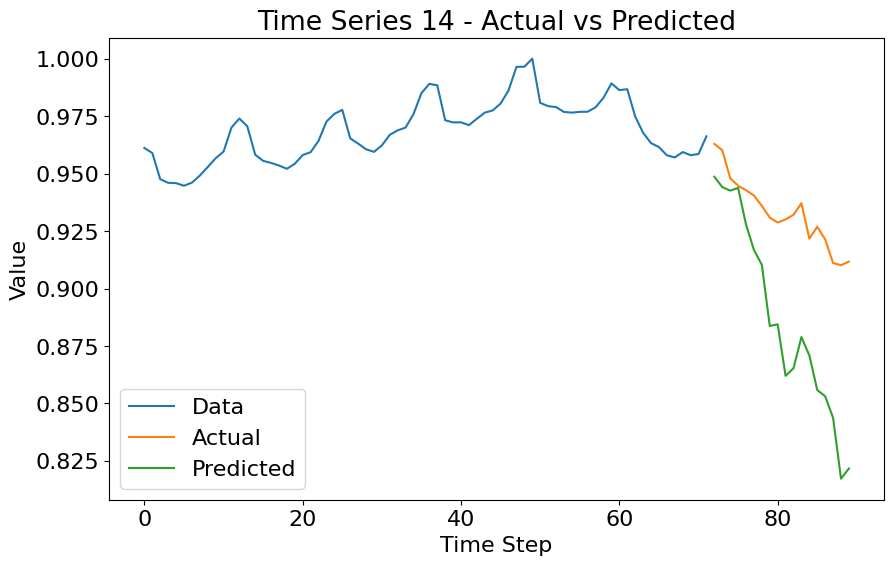

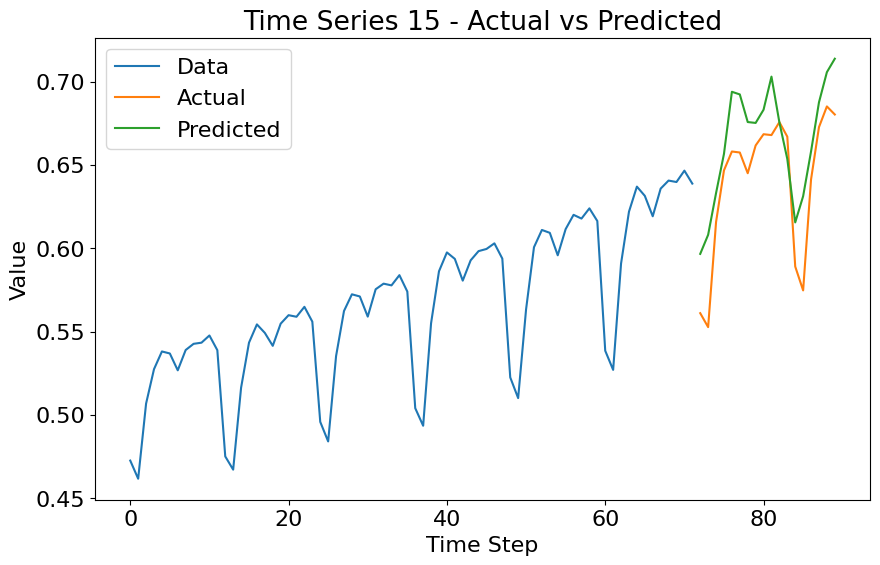

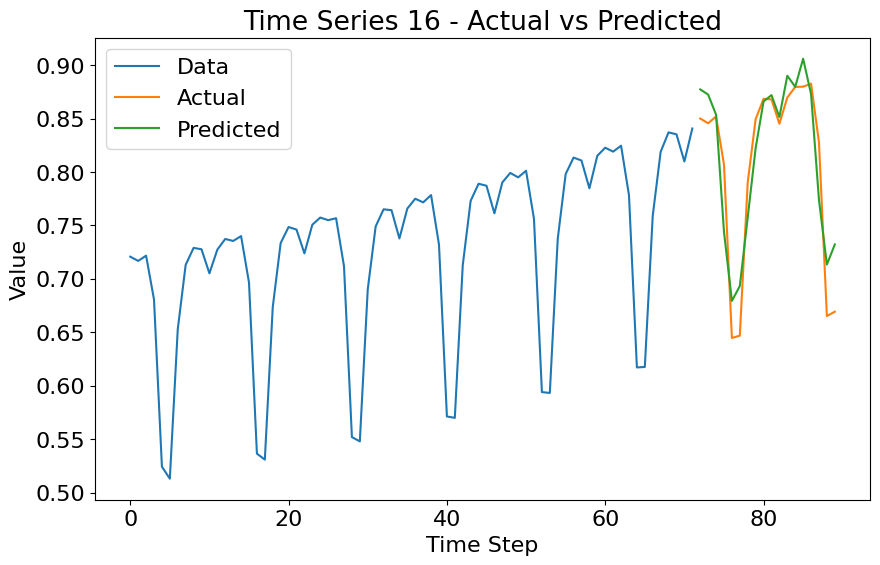

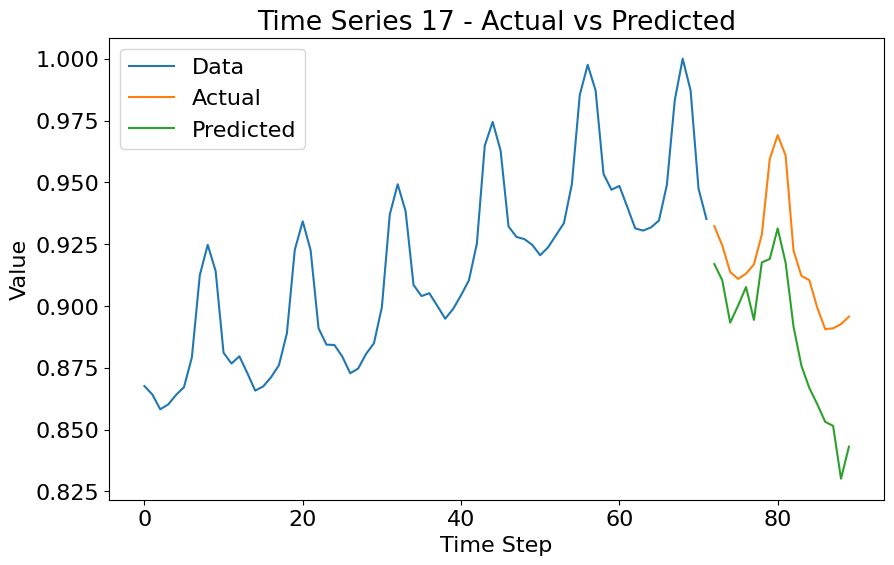

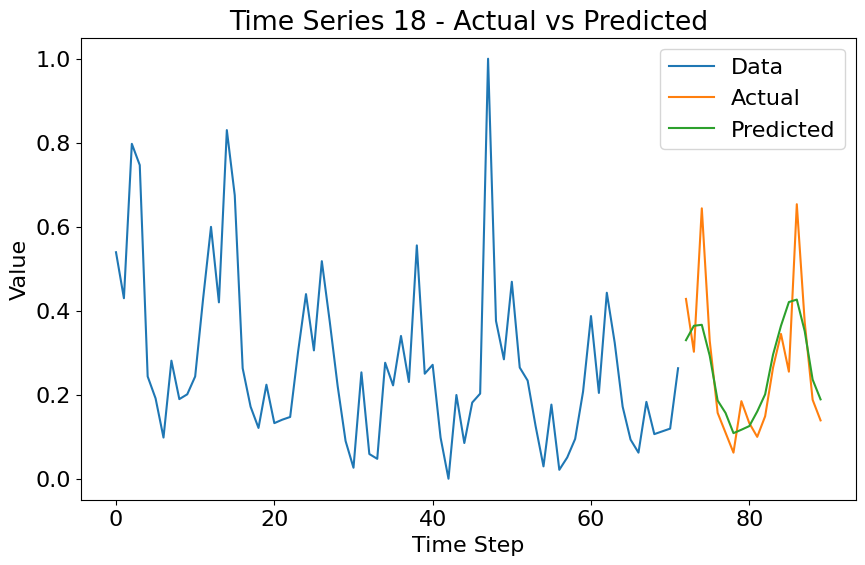

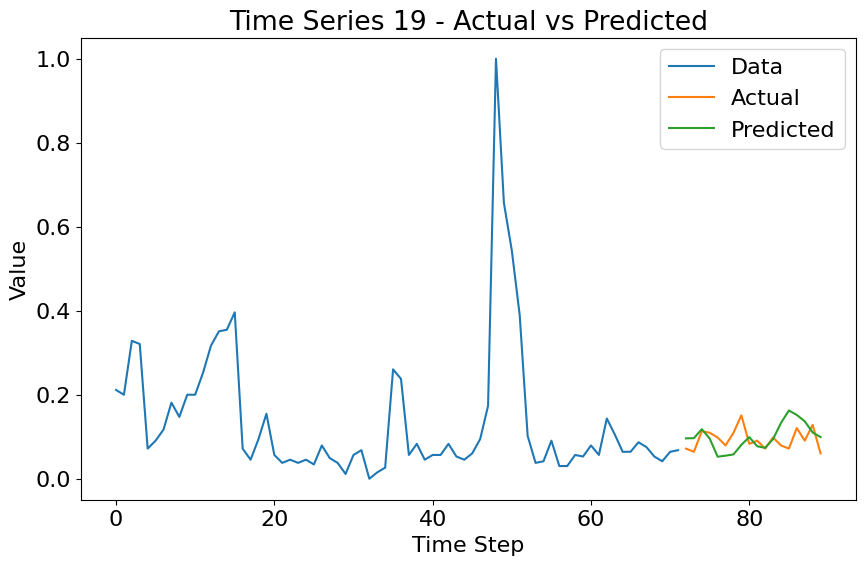

In [26]:
# plot predictions from specific model
from C2.notebooks.Utils import plot_predictions
for i in range(20):
    # def plot_predictions(test_data, predictions, test_labels, series_index):
    # i = np.random.randint(0, len(dataset))
    plot_predictions(dataset, predictions_all[:, :, 4], labels, i)

In [13]:
# ENSEMBLE MODEL average
predictions = np.mean(predictions_all, axis=2)
# predictions_all = np.zeros((labels.shape[0], labels.shape[1], len(models)))
# for i, model_name in enumerate(models):
#     print(model_name)
#     model = tfk.models.load_model('../ensemble_models/models/' + model_name)
#     if "cat" in model_name.lower():
#         predictions += model.predict([dataset, categories]) / len(models)
#         predictions_all[:, :, i] = model.predict([dataset, categories])
#     else:
#         predictions += model.predict(dataset) / len(models)
#         predictions_all[:, :, i] = model.predict(dataset)
# 


0052_ENC_DEC_FF_model.h5
1500/1500 [==============================] - 10s 7ms/step
0059LSTM_ENC_DEC_model_attention_localMAE112_MSE0254__6epochs.h5
   9/1500 [..............................] - ETA: 9s   

W0000 00:00:1703077952.417600   12267 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1060" frequency: 1733 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5768871936 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1500/1500 [==============================] - 10s 6ms/step
0055_CNN_LSTM_CATEGORIES__OVERFIT_085_0164
1500/1500 [==============================] - 9s 6ms/step
0065_resnet_5blocks_20epochs.h5
1500/1500 [==============================] - 7s 5ms/step
0073_resnet_3blocks.h5
1500/1500 [==============================] - 10s 6ms/step
0055_CNN_LSTM_109_0253
1500/1500 [==============================] - 14s 9ms/step
LSTM_best_18.h5
1500/1500 [==============================] - 5s 4ms/step
0060mix_conv_lstm_conv_11_0255
1500/1500 [==============================] - 14s 9ms/step


In [ ]:
predictions_mean_weighted = np.zeros((labels.shape[0], labels.shape[1]))
for i, model_name in enumerate(models):
    print(model_name)
    model = tfk.models.load_model('../ensemble_models/models/' + model_name)
    if "cat" in model_name.lower():
        predictions_mean_weighted += model.predict([dataset, categories]) * dataframe.iloc[i]['mae']
    else:
        predictions_mean_weighted += model.predict(dataset) * dataframe.iloc[i]['mae']

MAE:  0.07722297699452588
MSE:  0.012944079798778589


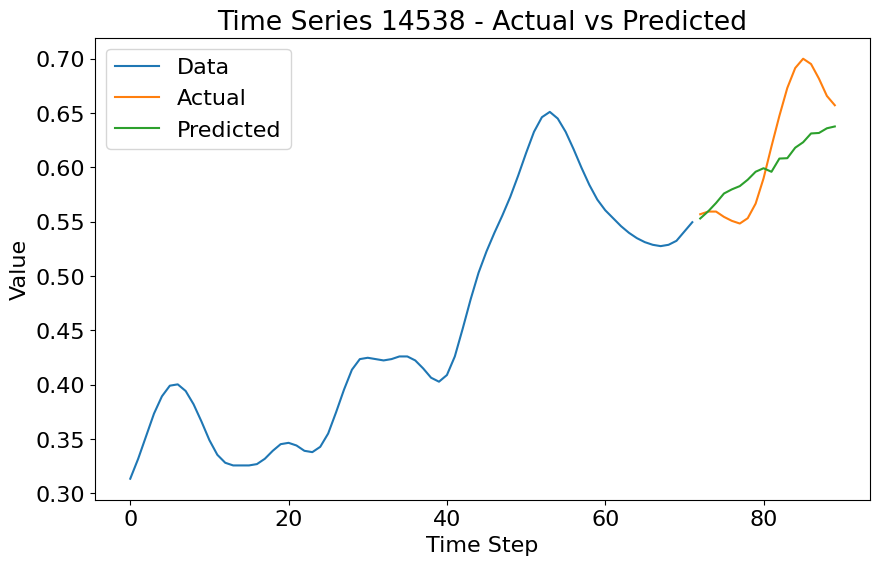

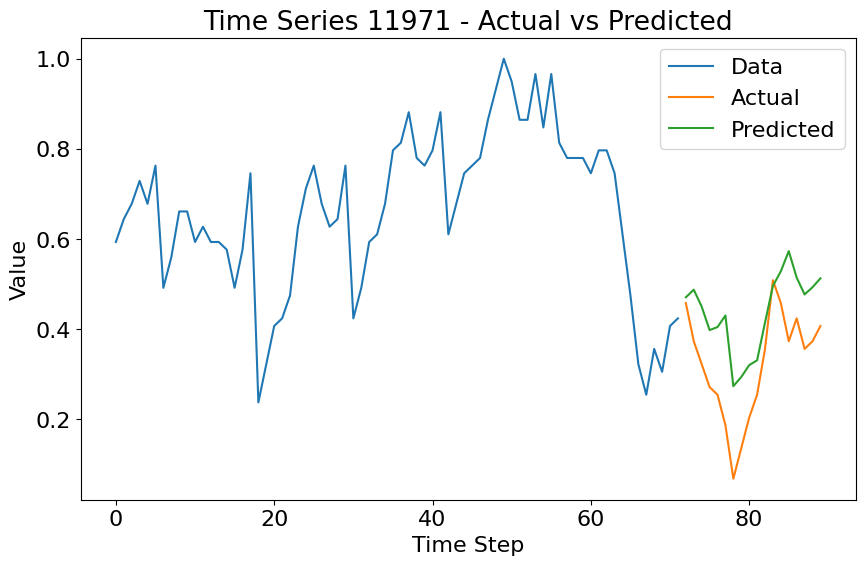

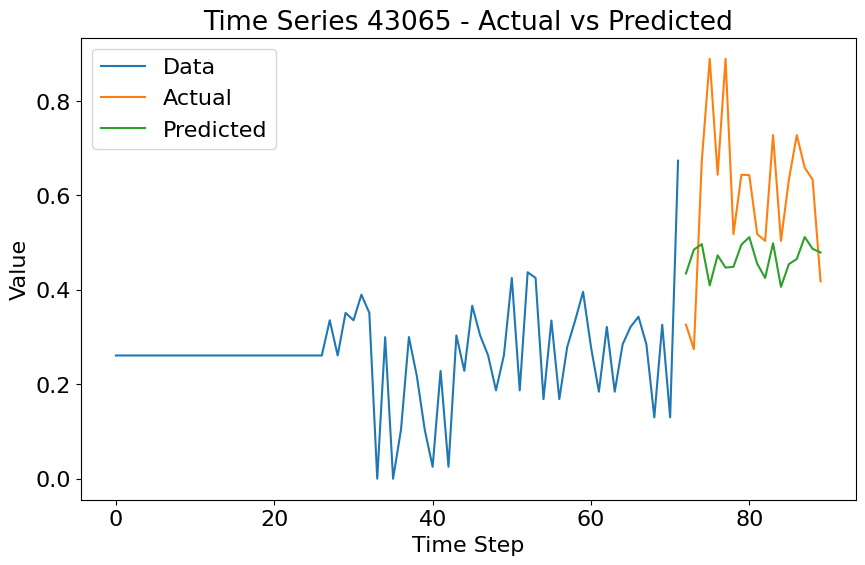

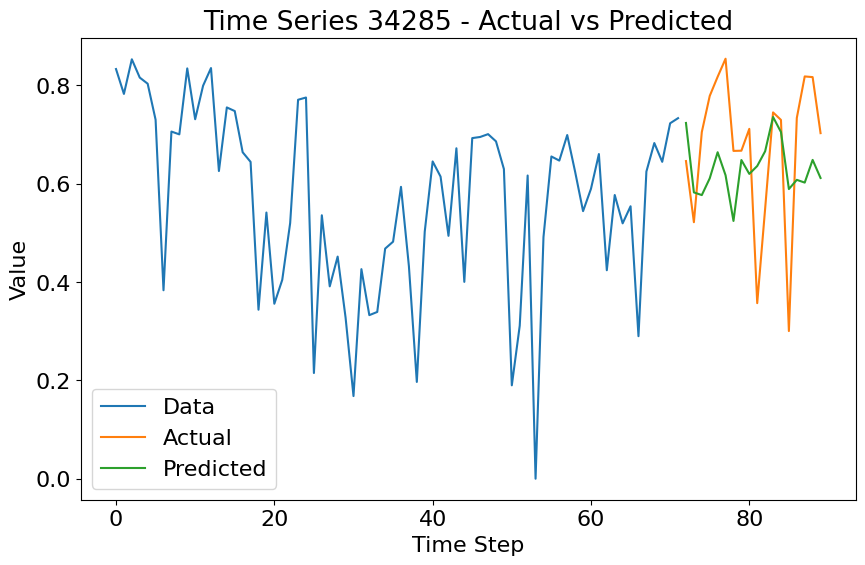

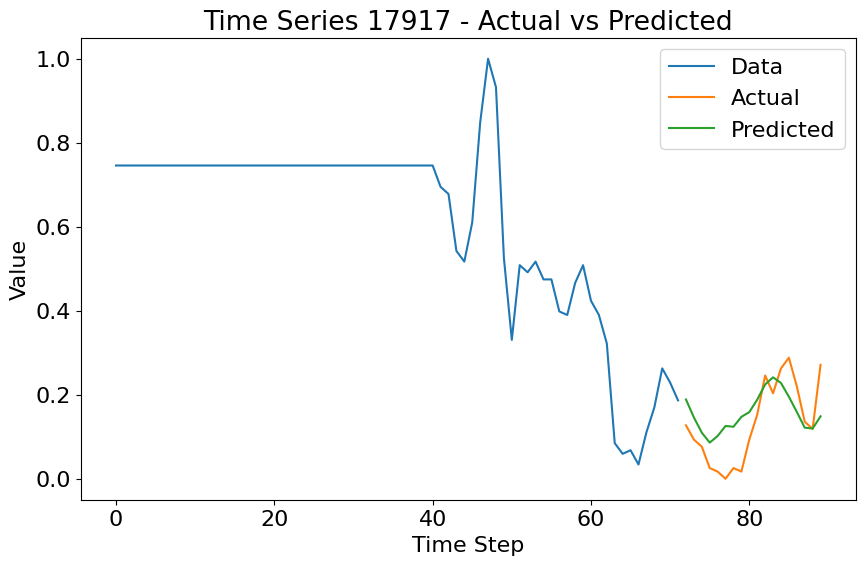

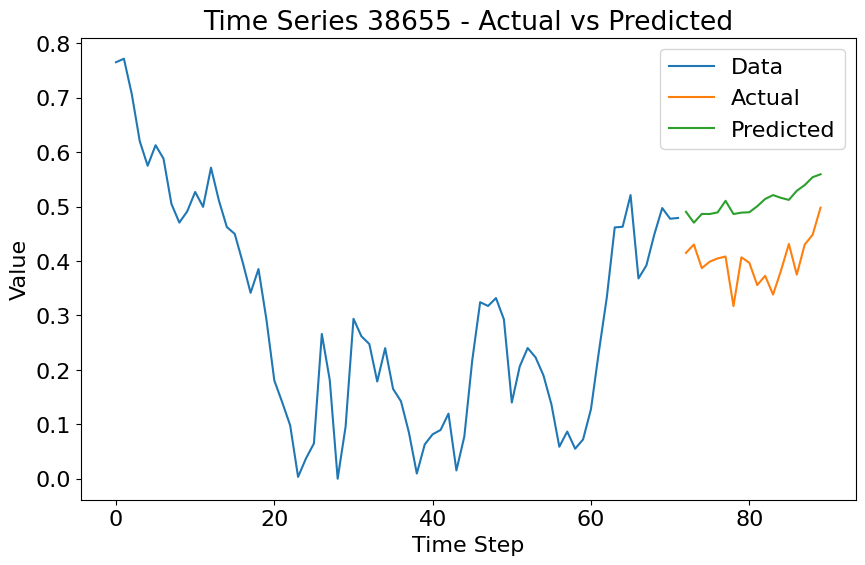

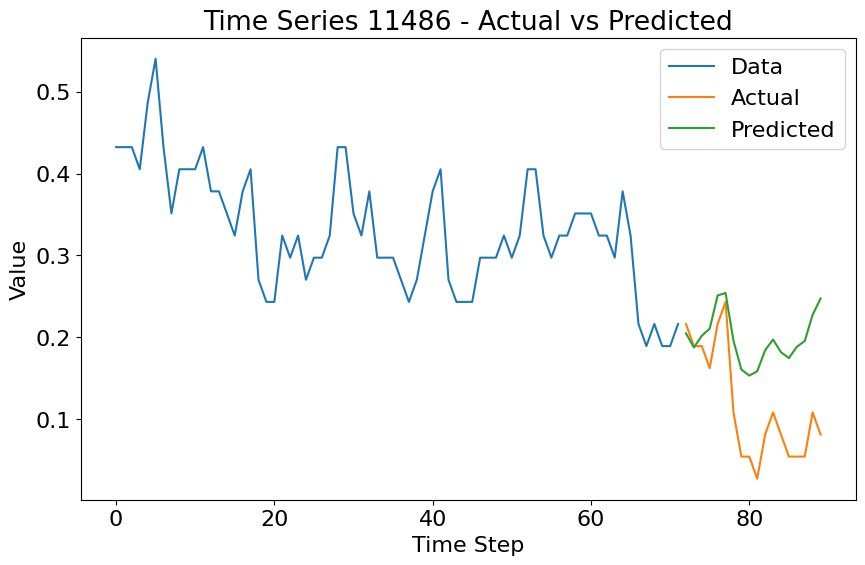

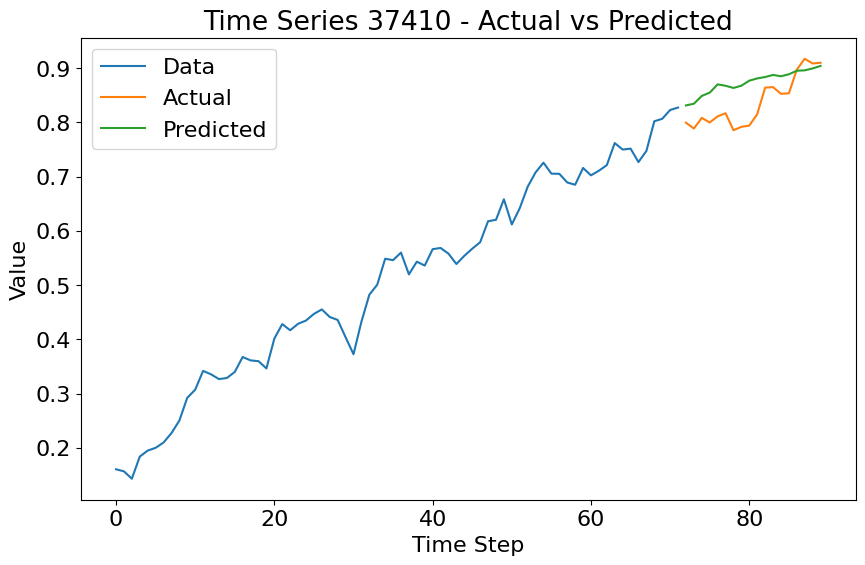

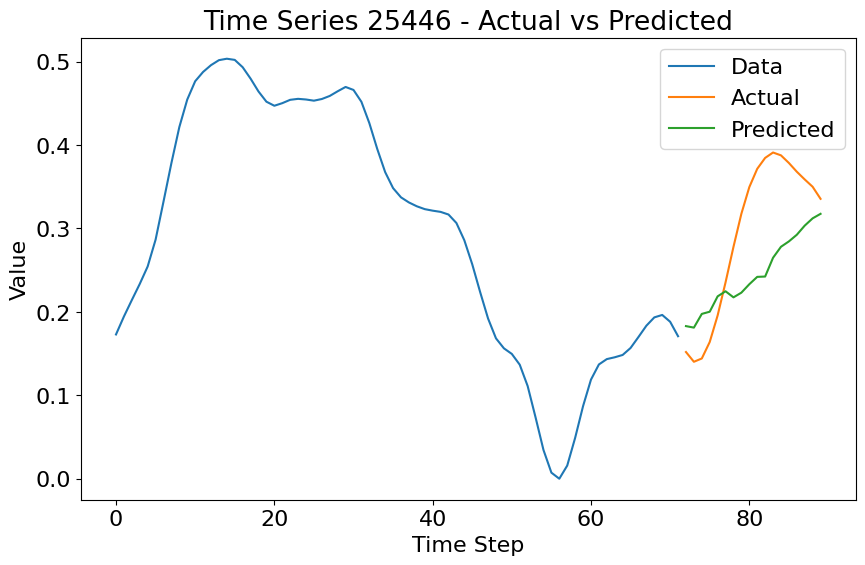

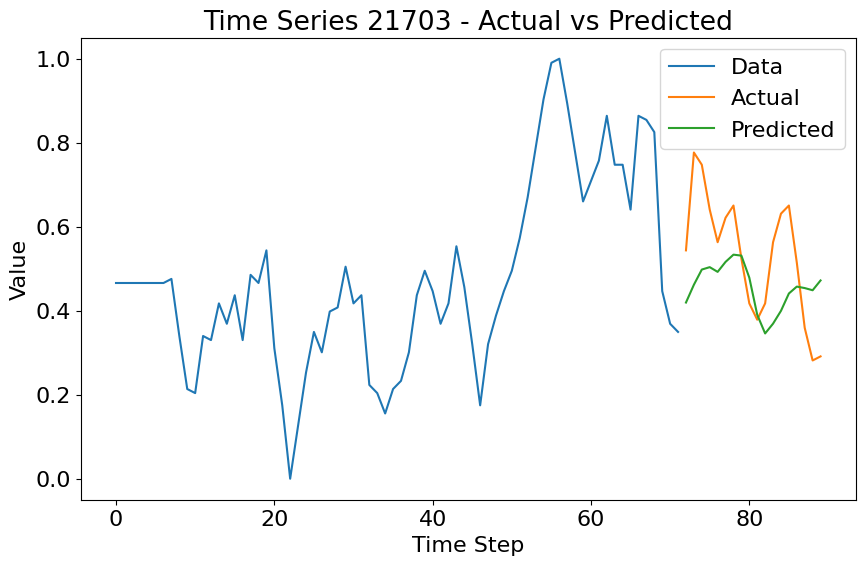

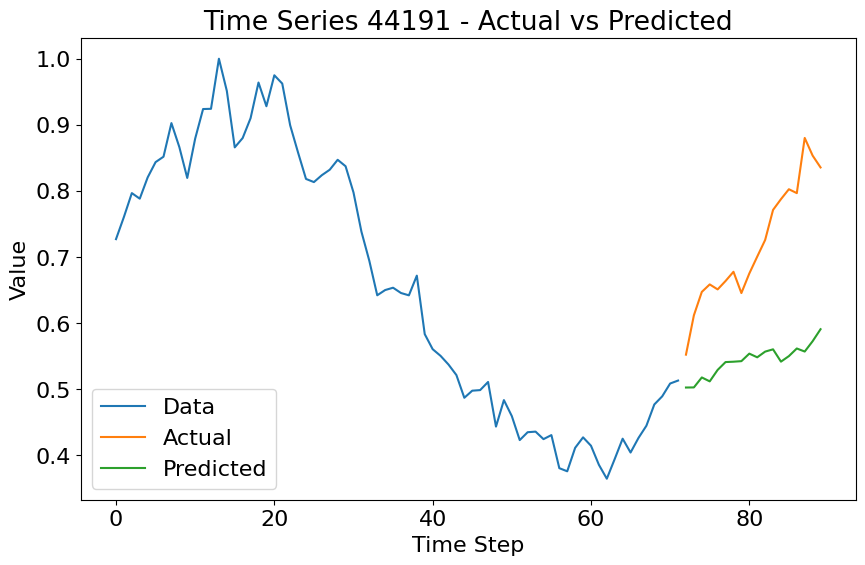

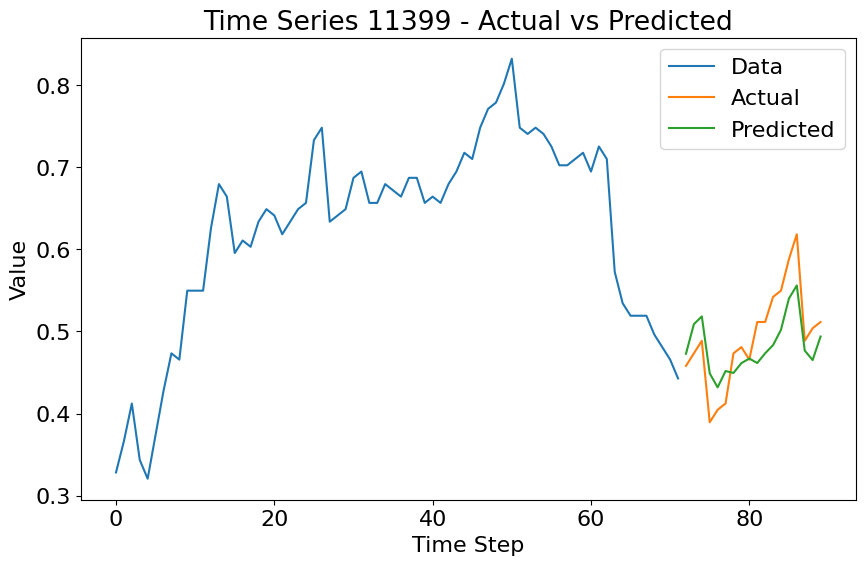

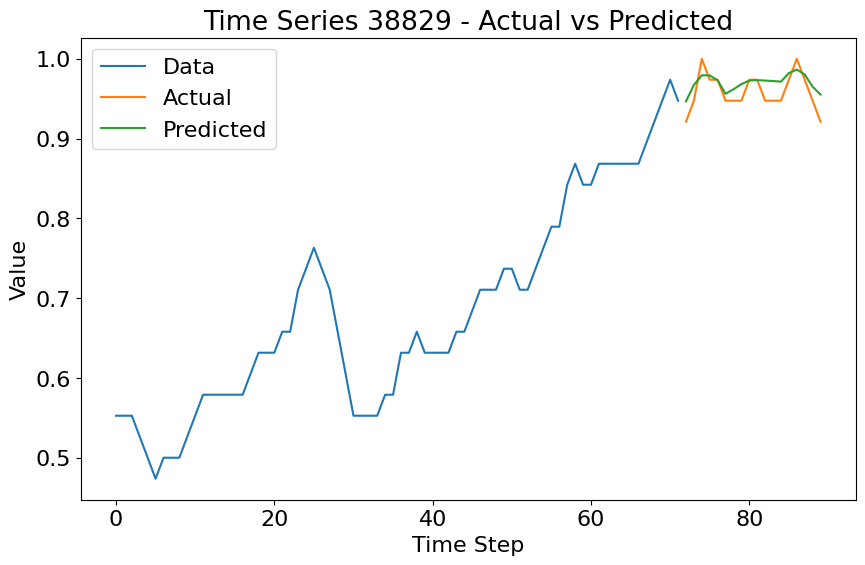

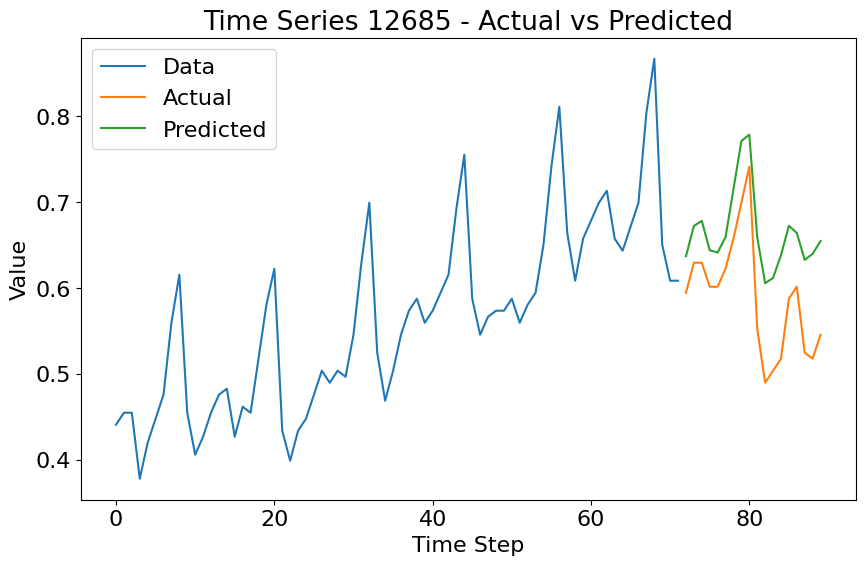

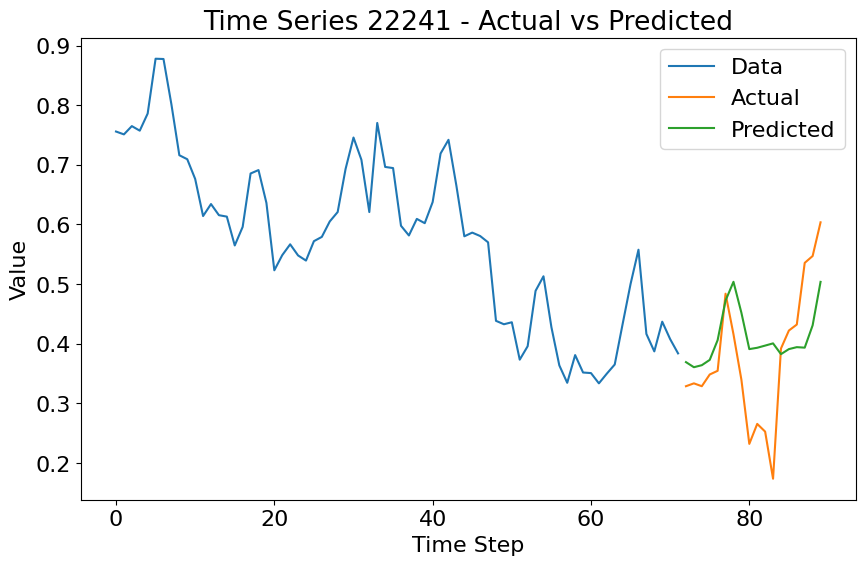

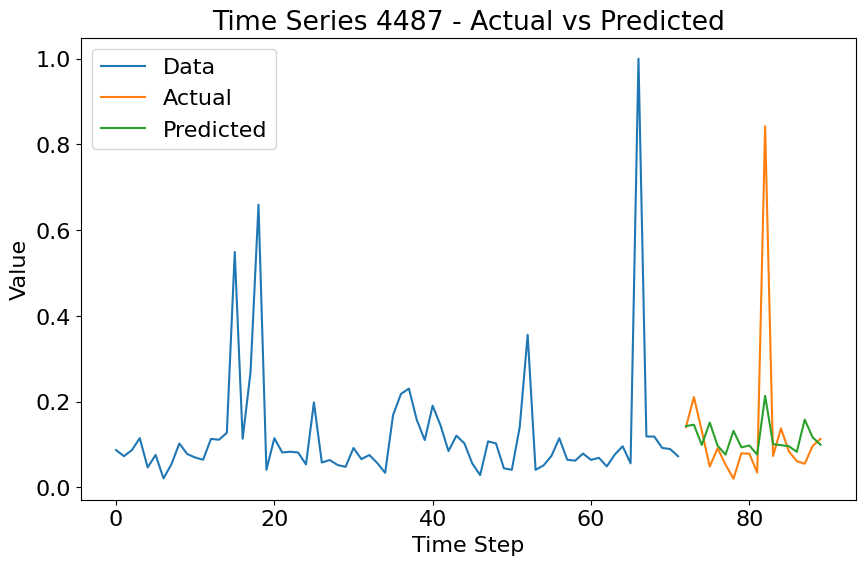

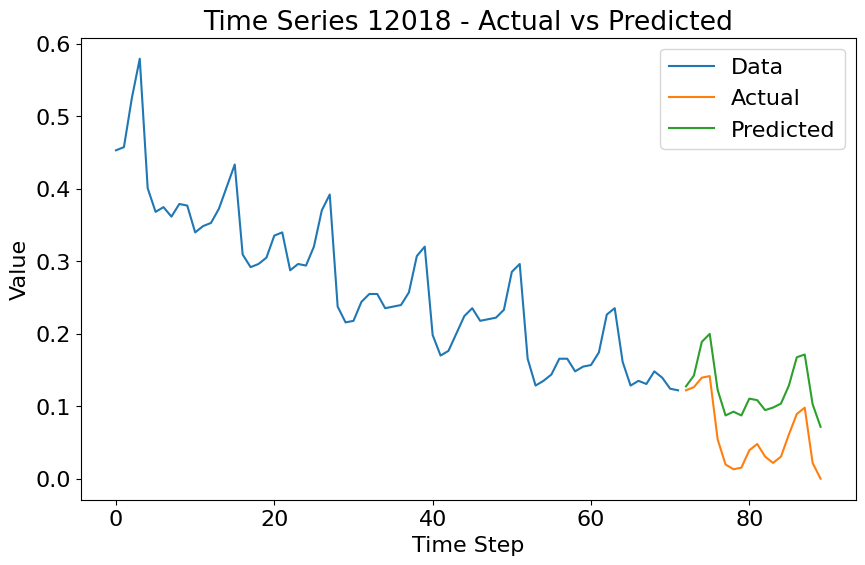

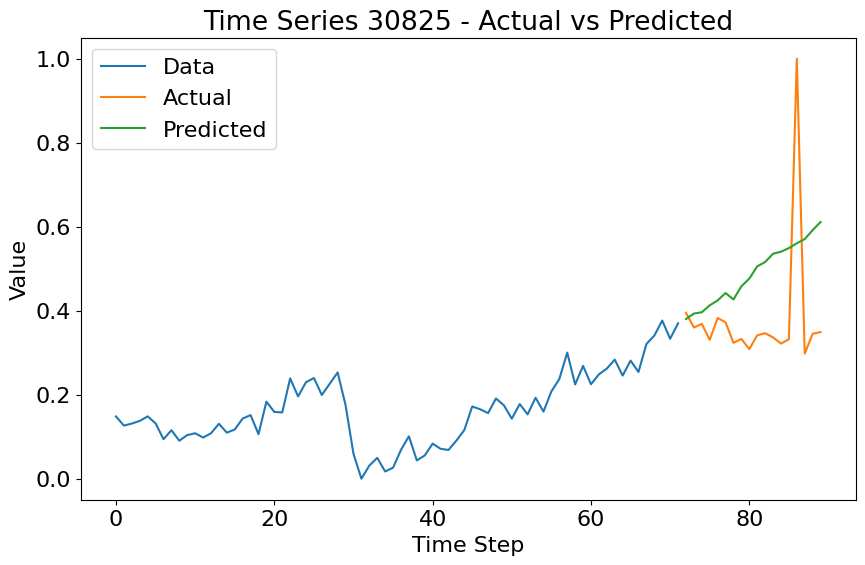

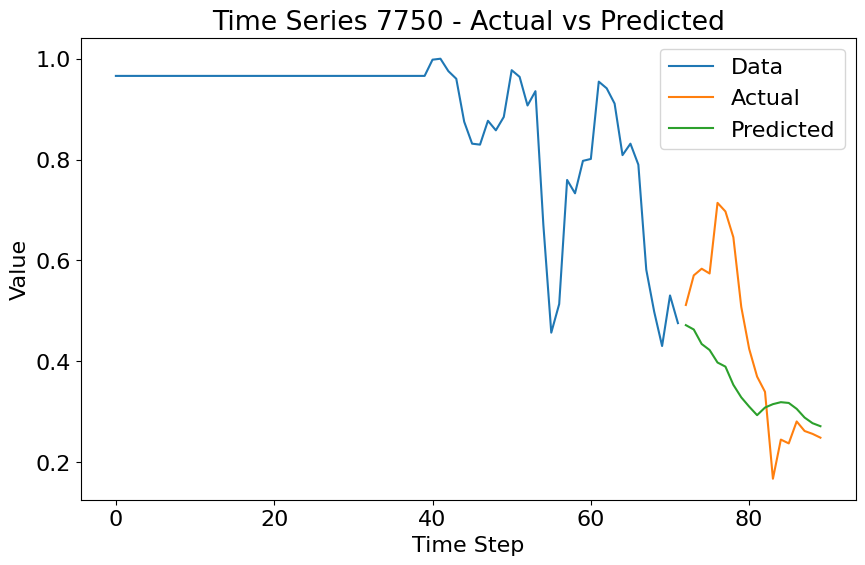

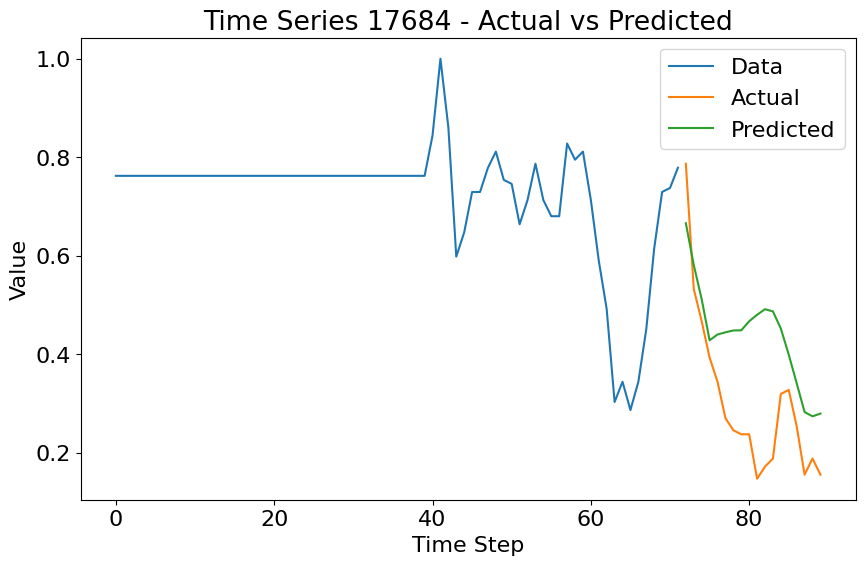

In [14]:
from C2.notebooks.Utils import plot_predictions

# evaluate the ensemble model
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("MAE: ", mean_absolute_error(labels, predictions))
print("MSE: ", mean_squared_error(labels, predictions))

#plot some predictions with Utils
for _ in range(20):
    # def plot_predictions(test_data, predictions, test_labels, series_index):
    i = np.random.randint(0, len(dataset))
    plot_predictions(dataset, predictions, labels, i)

In [12]:
dataset.shape

(48000, 200, 1)

In [10]:
# ENSEMBLE MODEL, xgboost and keras
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

from tensorflow.keras import layers as tfkl
from tensorflow.keras import models as tfkm
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers as tfko

dataset = dataset.reshape((dataset.shape[0], dataset.shape[1], 1))

train, test, train_labels, test_labels, train_categories, test_categories, train_predictions, test_predictions = train_test_split(dataset, labels, categories, predictions_all, test_size=0.2, random_state=seed)
#predictions_all.reshape((predictions_all.shape[0], -1))

# ensemble_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 100, random_state=seed)
# 
# X_train = np.concatenate((train_categories, train_predictions), axis=1)
# X_test = np.concatenate((test_categories, test_predictions), axis=1)
# # X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
# # X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
# ensemble_model.fit(X_train, train_labels)
# y_pred = ensemble_model.predict(X_test)

# print("MAE: ", mean_absolute_error(y_test, y_pred))


# keras

def build_model():
    input_predictions = tfkl.Input(shape=(train_predictions.shape[1], train_predictions.shape[2]))
    input_categories = tfkl.Input(shape=(train_categories.shape[1], ))
    # input_history = tfkl.Input(shape=(train.shape[1], train.shape[2]))
    # input_history_lstm = tfkl.LSTM(18, return_sequences=False)(input_history)
    # input_history_lstm = tfkl.Flatten()(input_history_lstm)

    # input_predictions_lstm = tfkl.LSTM(18, return_sequences=True)(input_predictions)
    # input_predictions_lstm = tfkl.Flatten()(input_predictions_lstm)
    input_predictions_flat = tfkl.Flatten()(input_predictions)
    input_categories_flat = tfkl.Flatten()(input_categories)
    
    x = tfkl.Concatenate()([input_predictions_flat, input_categories_flat])
    x = tfkl.Dense(13, activation = 'relu')(x)
    output = tfkl.Dense(train_labels.shape[1], activation='linear')(x)
    model = tfkm.Model(inputs=[input_predictions, input_categories], outputs=output)
    model.compile(optimizer=tfko.Adam(learning_rate=0.001), loss='mae', metrics=['mae', 'mse'])
    return model

model = build_model()
model.fit([train_predictions, train_categories], train_labels, epochs=45, batch_size=256, verbose=1)
y_pred = model.predict([test_predictions, test_categories])
print("MAE: ", mean_absolute_error(test_labels, y_pred))
print("MSE: ", mean_squared_error(test_labels, y_pred))


Epoch 1/45
150/150 [==============================] - 1s 3ms/step - loss: 0.1845 - mae: 0.1845 - mse: 0.0853
Epoch 2/45
150/150 [==============================] - 0s 3ms/step - loss: 0.0887 - mae: 0.0887 - mse: 0.0159
Epoch 3/45
150/150 [==============================] - 0s 3ms/step - loss: 0.0839 - mae: 0.0839 - mse: 0.0147
Epoch 4/45
150/150 [==============================] - 0s 2ms/step - loss: 0.0815 - mae: 0.0815 - mse: 0.0141
Epoch 5/45
150/150 [==============================] - 0s 3ms/step - loss: 0.0799 - mae: 0.0799 - mse: 0.0137
Epoch 6/45
150/150 [==============================] - 0s 3ms/step - loss: 0.0778 - mae: 0.0778 - mse: 0.0132
Epoch 7/45
150/150 [==============================] - 0s 3ms/step - loss: 0.0759 - mae: 0.0759 - mse: 0.0127
Epoch 8/45
150/150 [==============================] - 0s 3ms/step - loss: 0.0749 - mae: 0.0749 - mse: 0.0125
Epoch 9/45
150/150 [==============================] - 0s 3ms/step - loss: 0.0742 - mae: 0.0742 - mse: 0.0123
Epoch 10/45
150/150

In [11]:
model.save('../ensemble_models/ensemble_model.h5')

In [10]:
# save ensemble model
import pickle
pickle.dump(ensemble_model, open('../ensemble_models/ensemble_model.pickle', 'wb'))

NameError: name 'ensemble_model' is not defined

In [10]:
weights = ( (np.exp(-dataframe["mae"]))/ sum(np.exp(-dataframe["mae"]))).tolist()
weights

[0.028177310960276557,
 0.02786044981586021,
 0.02866168467702228,
 0.027682910950550817,
 0.02761319497005133,
 0.027958027872119703,
 0.027903717854553558,
 0.027818008078724726,
 0.027906908757273738,
 0.027830262444284857,
 0.02720873849309764,
 0.02795182019323629,
 0.02736378206684725,
 0.027526690961189277,
 0.0274814329089786,
 0.027702533801077903,
 0.027307665571745972,
 0.02771372012290718,
 0.027982523499634347,
 0.027494225888196003,
 0.028249279401396904,
 0.027501547260222317,
 0.027574094695227796,
 0.02768924447188772,
 0.027819285482434338,
 0.027664778008725886,
 0.027807036912801272,
 0.028064035203083627,
 0.02768030909944052,
 0.028397545140025227,
 0.02759859042187325,
 0.02761319497005133,
 0.02778407671307875,
 0.027853420395567003,
 0.027714971332085187,
 0.02784298060447061]

In [ ]:
#multioutput regressor
# from sklearn.multioutput import MultiOutputRegressor
# from sklearn.svm import *
# 
# 
# svm_model = MultiOutputRegressor(SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))
# svm_model.fit(train_predictions.reshape((train_predictions.shape[0], train_predictions.shape[1]*train_predictions.shape[2])), train_labels)
# y_pred = svm_model.predict(test_predictions.reshape((test_predictions.shape[0], test_predictions.shape[1]*test_predictions.shape[2])))
# 
# print("MAE: ", mean_absolute_error(test_labels, y_pred))

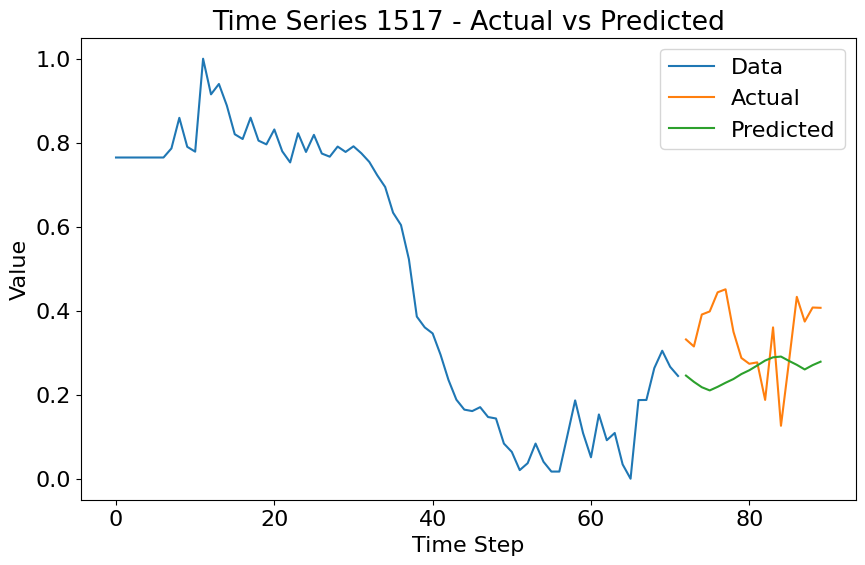

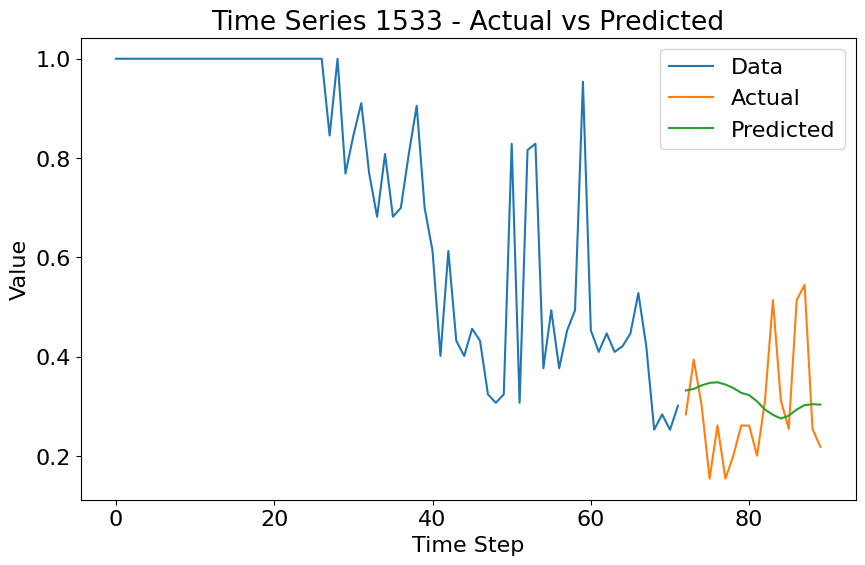

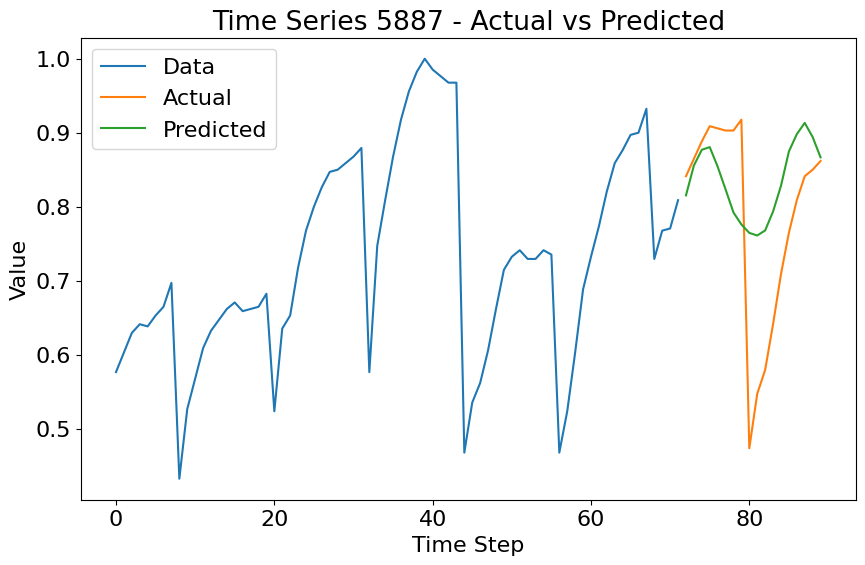

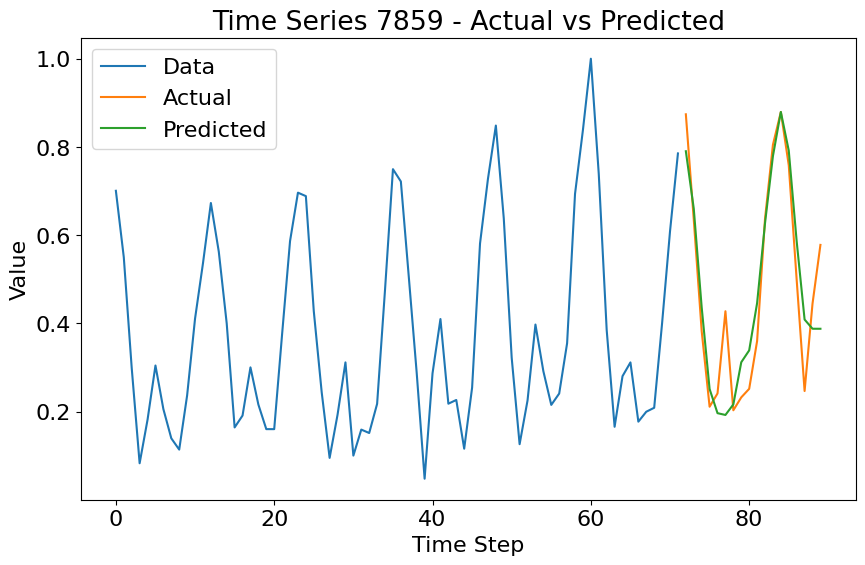

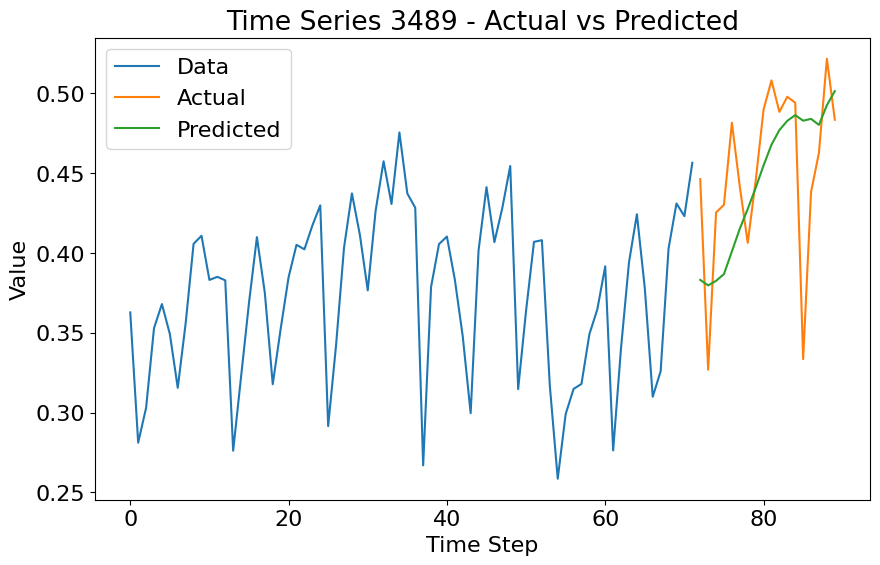

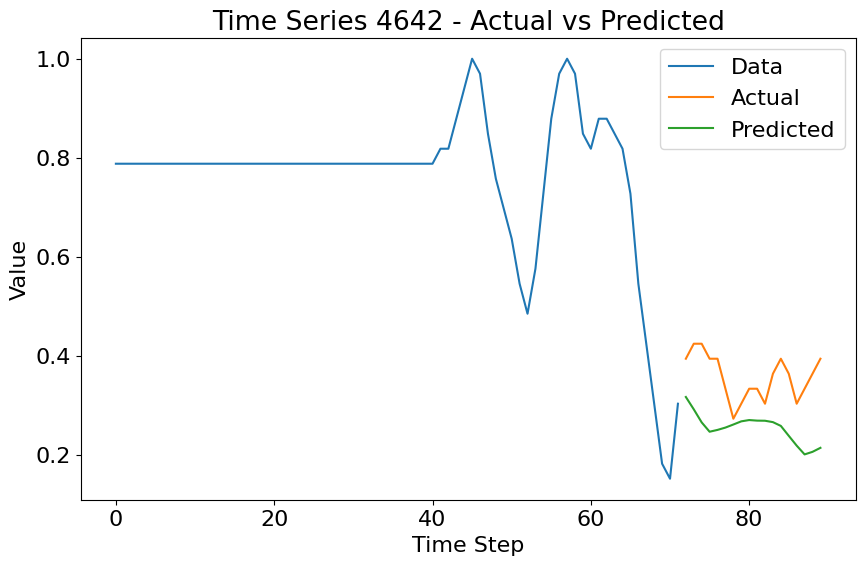

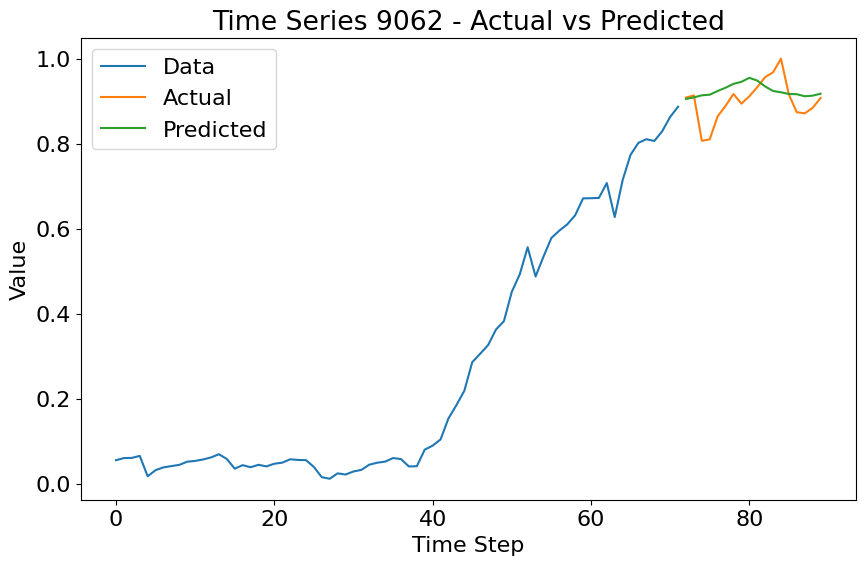

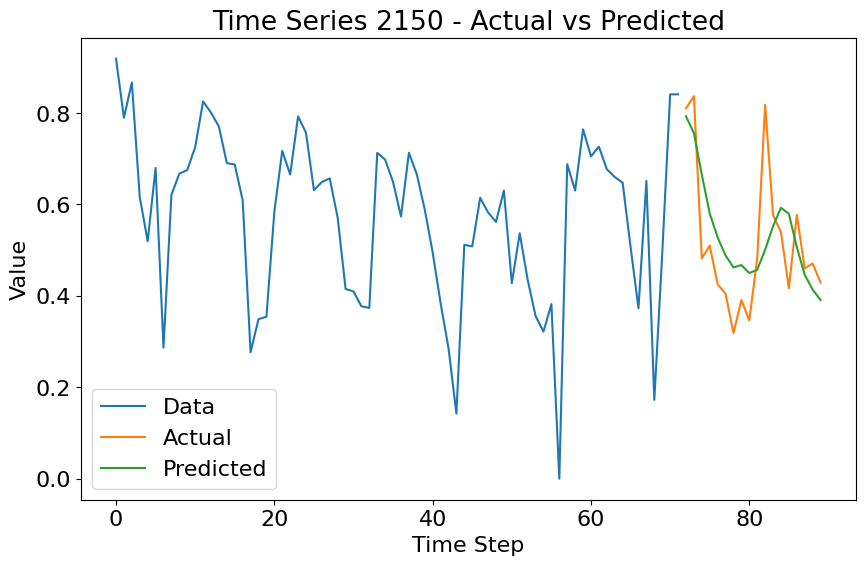

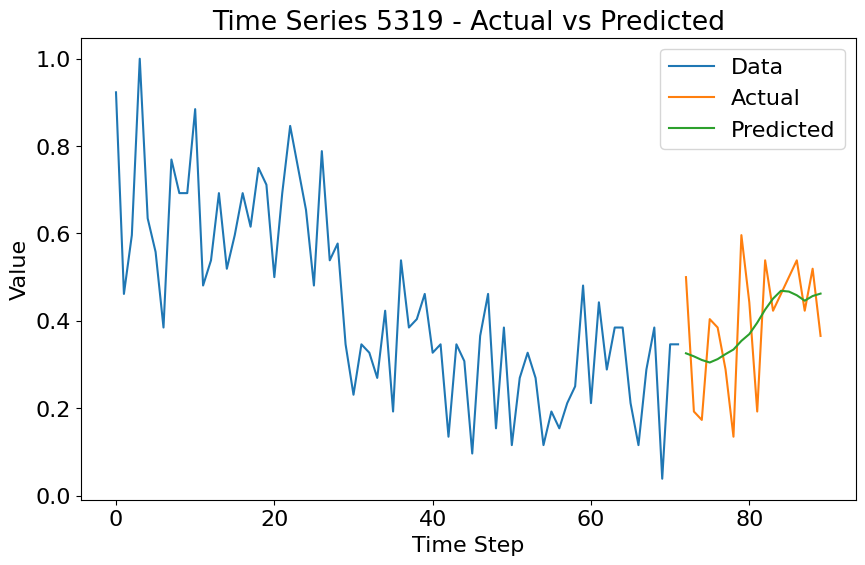

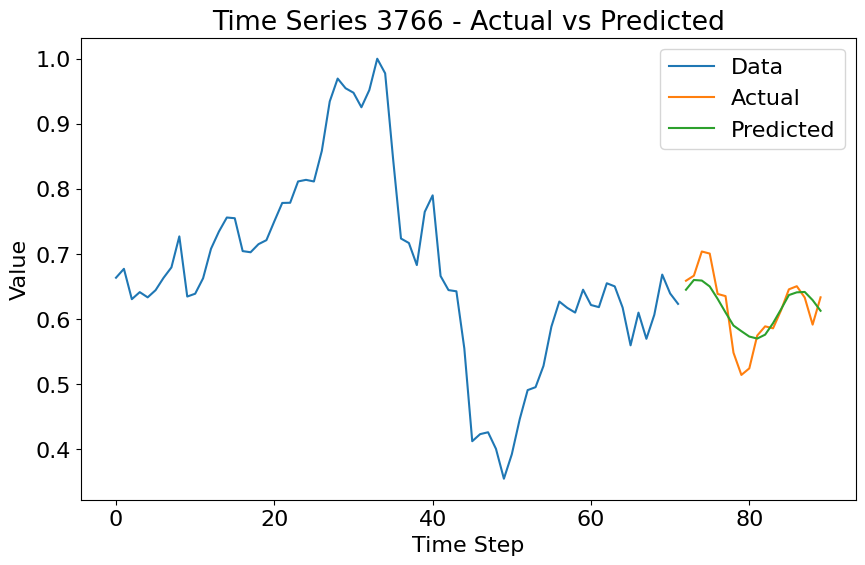

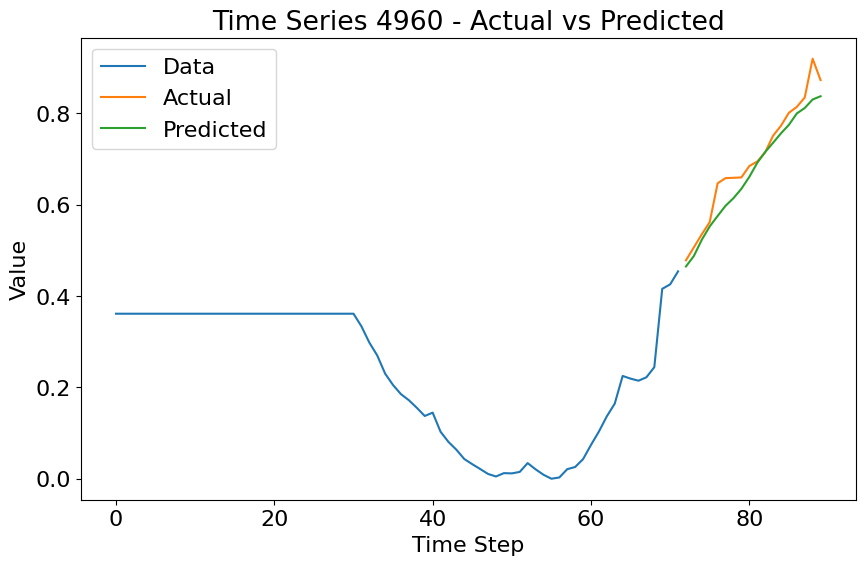

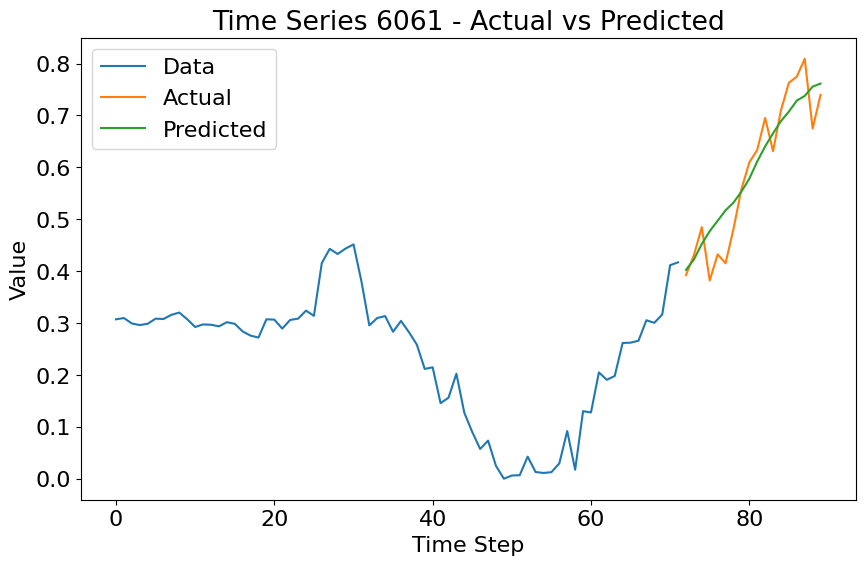

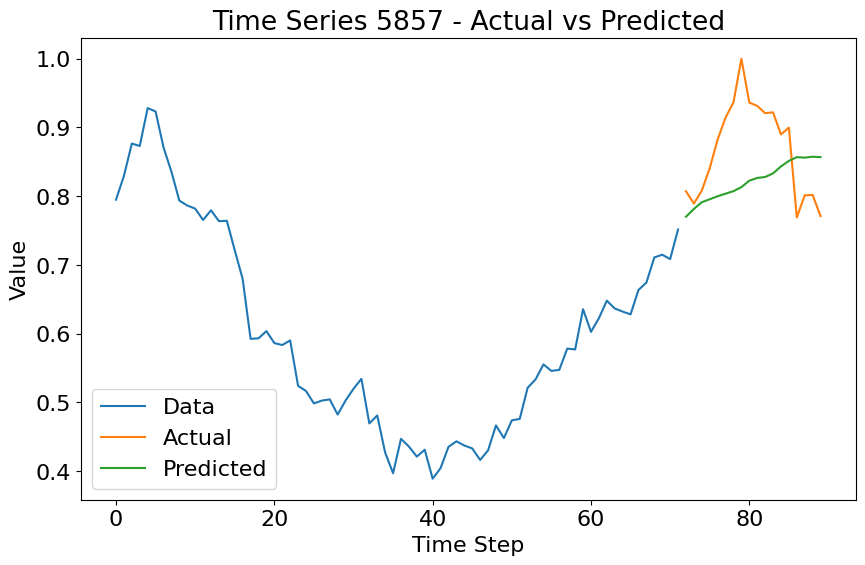

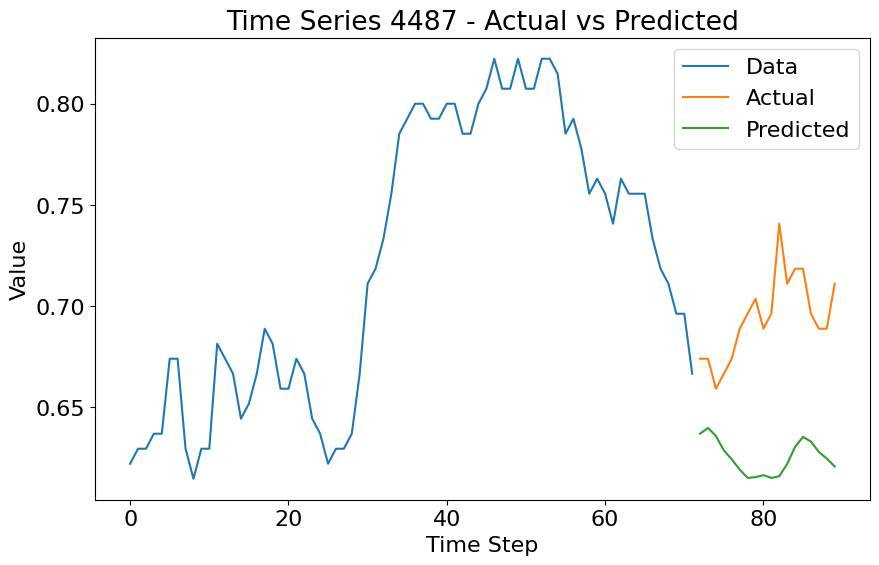

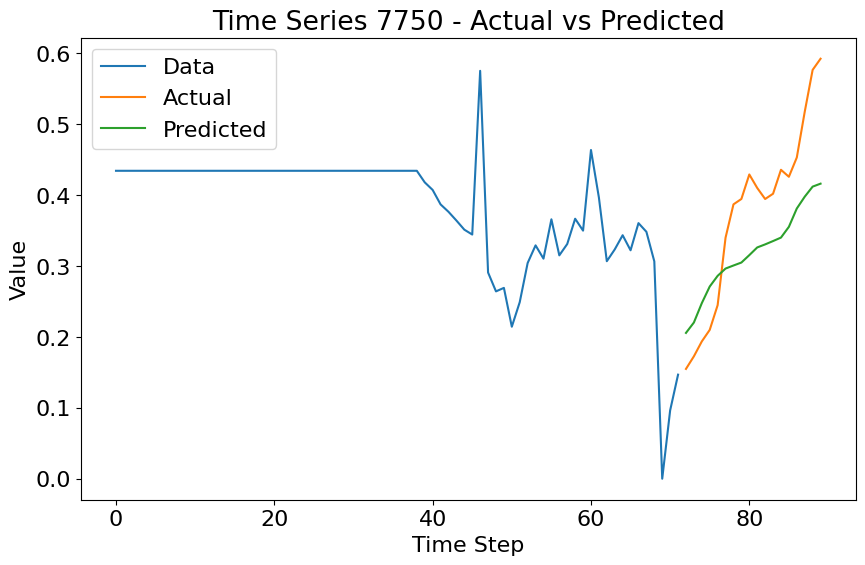

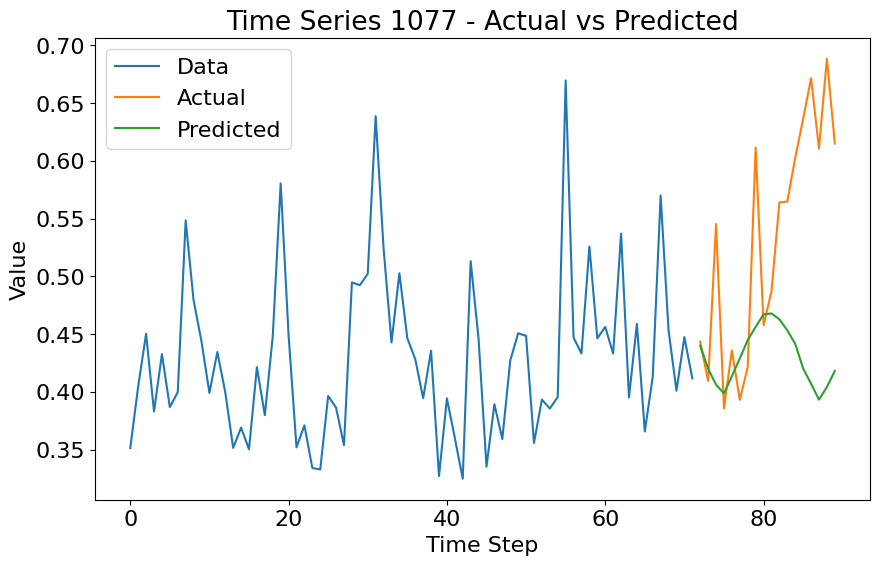

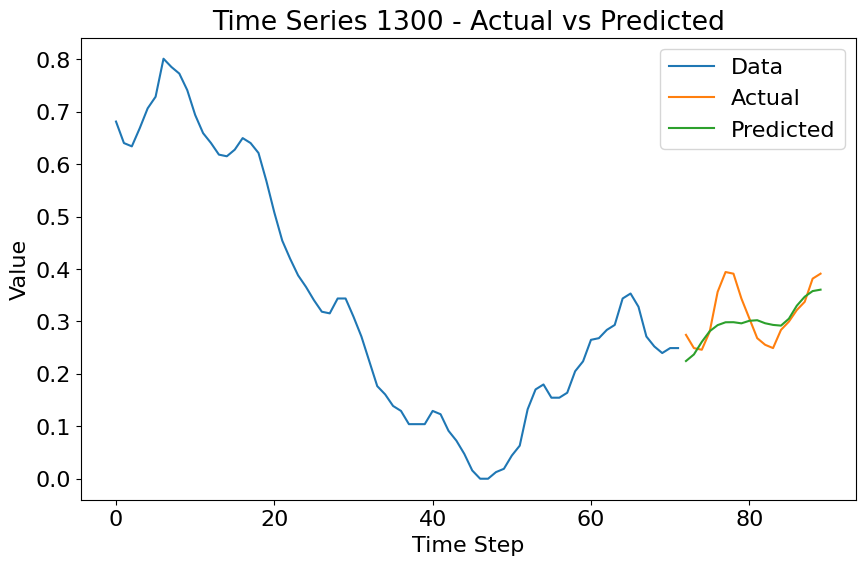

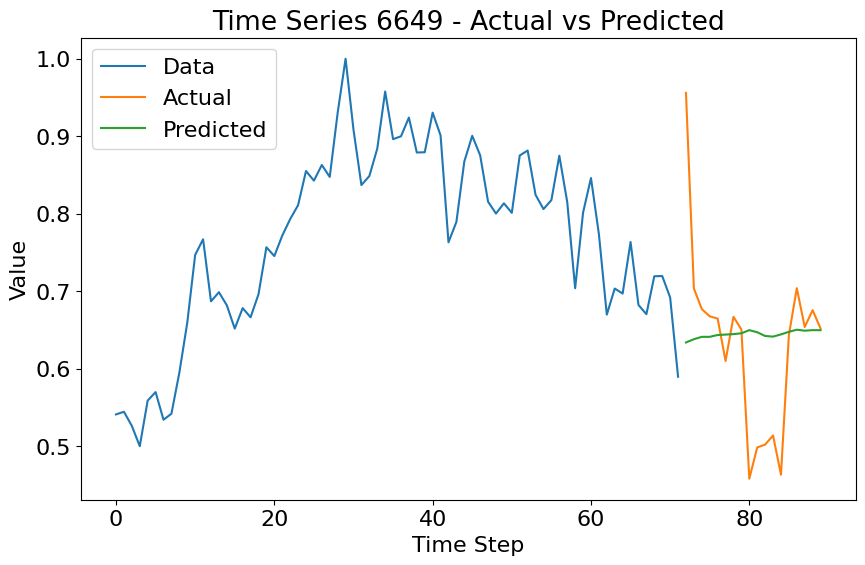

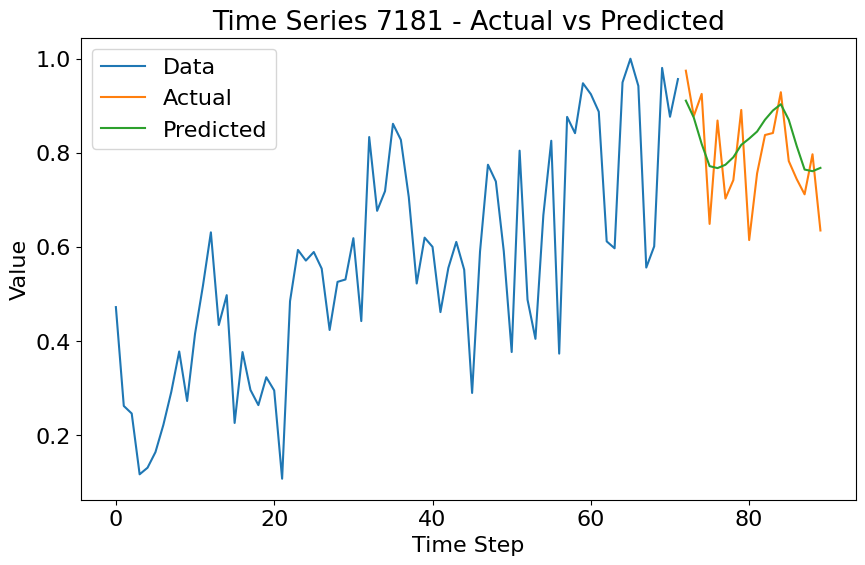

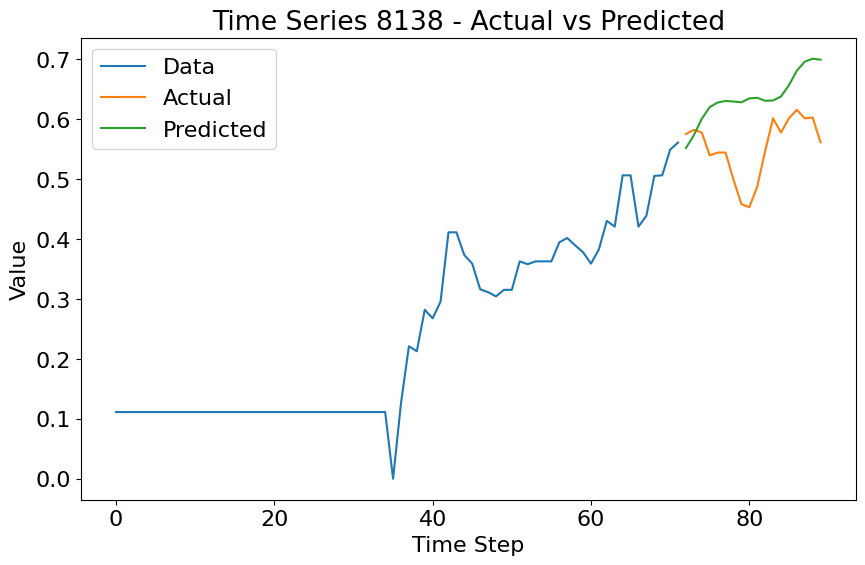

In [8]:
import C2.notebooks.Utils as Utils
for _ in range(20):
    # def plot_predictions(test_data, predictions, test_labels, series_index):
    i = np.random.randint(0, len(test))
    Utils.plot_predictions(test, y_pred, test_labels, i)